In [119]:
"""
Downloading data
"""
from nba_api.stats.endpoints import leaguegamefinder
import pandas as pd
import numpy as np
import time

years = range(1, 26)
seasons = [f"20{i:02d}-{(i+1)%100:02d}" for i in years]

to_merge = []
for s in seasons:
    time.sleep(1)
    finder = leaguegamefinder.LeagueGameFinder(
        season_nullable=s,
        season_type_nullable="Regular Season",
        league_id_nullable='00'
    )

    game_df = finder.get_data_frames()[0]
    to_merge.append(game_df)

games_df = pd.concat(to_merge)

In [120]:
"""Time-aware splitter that purges a gap between train and validation groups."""
import numpy as np

class PurgedGroupTimeSeriesSplit:
    """Drop-in replacement for TimeSeriesSplit with group-aware purging."""
    def __init__(self, n_splits=5, *, group_gap=1, max_train_group_size=None, test_group_size=None):
        if n_splits < 2:
            raise ValueError("n_splits must be at least 2")
        self.n_splits = n_splits
        self.group_gap = int(group_gap)
        self.max_train_group_size = max_train_group_size
        self.test_group_size = test_group_size

    def split(self, X, y=None, groups=None):
        if groups is None:
            raise ValueError("PurgedGroupTimeSeriesSplit requires 'groups' (e.g. normalized dates)")
        groups = np.asarray(groups)
        unique, first_idx = np.unique(groups, return_index=True)
        order = np.argsort(first_idx)
        unique_groups = unique[order]
        group_to_pos = {g: i for i, g in enumerate(unique_groups)}
        group_ids = np.fromiter((group_to_pos[g] for g in groups), dtype=int, count=len(groups))
        n_groups = len(unique_groups)
        if self.n_splits >= n_groups:
            raise ValueError("Too few unique groups for the requested number of splits")

        test_size = self.test_group_size or max(1, n_groups // (self.n_splits + 1))

        for fold in range(self.n_splits):
            test_start = n_groups - (self.n_splits - fold) * test_size
            test_end = min(test_start + test_size, n_groups)
            if test_start <= 0:
                continue
            train_end = max(0, test_start - self.group_gap)
            if self.max_train_group_size is not None:
                train_start = max(0, train_end - int(self.max_train_group_size))
            else:
                train_start = 0

            train_mask = (group_ids >= train_start) & (group_ids < train_end)
            val_mask = (group_ids >= test_start) & (group_ids < test_end)
            train_idx = np.flatnonzero(train_mask)
            val_idx = np.flatnonzero(val_mask)
            if len(train_idx) == 0 or len(val_idx) == 0:
                continue
            yield train_idx, val_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits


In [121]:
"""
Merging games into single rows
"""

def merge_games(df):
    df['HOME'] = df['MATCHUP'].str.contains('vs.') 
    home_df = df[df['HOME']].copy()
    away_df = df[~df['HOME']].copy()

    merged = home_df.merge(
        away_df,
        on='GAME_ID',
        suffixes=('_home', '_away')
    )
    merged = merged.rename(columns={
        'SEASON_ID_home' : 'sid',
        'GAME_DATE_home': 'date',
        'TEAM_ABBREVIATION_home': 'team_home',
        'TEAM_ABBREVIATION_away': 'team_away',
        'PTS_home': 'score_home',
        'PTS_away': 'score_away'
    })

    merged["win_home"] = (merged["score_home"] > merged["score_away"]).astype(int)
    merged['margin'] = (merged['score_home'] - merged['score_away'])

    merged['date'] = pd.to_datetime(merged['date'])
    merged = merged.sort_values('date').reset_index(drop=True)
    drop_cols = [
    'TEAM_ID_home', 'TEAM_ID_away', 'TEAM_NAME_home', 'TEAM_NAME_away',
    'MATCHUP_home', 'MATCHUP_away', 'GAME_ID',
    'WL_home', 'WL_away', 'HOME_home', 'HOME_away']
    merged.drop(drop_cols, axis=1, inplace=True)
    return merged

games_df = merge_games(games_df)
print(games_df.columns)
games_df


Index(['sid', 'team_home', 'date', 'MIN_home', 'score_home', 'FGM_home',
       'FGA_home', 'FG_PCT_home', 'FG3M_home', 'FG3A_home', 'FG3_PCT_home',
       'FTM_home', 'FTA_home', 'FT_PCT_home', 'OREB_home', 'DREB_home',
       'REB_home', 'AST_home', 'STL_home', 'BLK_home', 'TOV_home', 'PF_home',
       'PLUS_MINUS_home', 'SEASON_ID_away', 'team_away', 'GAME_DATE_away',
       'MIN_away', 'score_away', 'FGM_away', 'FGA_away', 'FG_PCT_away',
       'FG3M_away', 'FG3A_away', 'FG3_PCT_away', 'FTM_away', 'FTA_away',
       'FT_PCT_away', 'OREB_away', 'DREB_away', 'REB_away', 'AST_away',
       'STL_away', 'BLK_away', 'TOV_away', 'PF_away', 'PLUS_MINUS_away',
       'win_home', 'margin'],
      dtype='object')


,sid,team_home,date,MIN_home,score_home,FGM_home,FGA_home,FG_PCT_home,FG3M_home,FG3A_home,FG3_PCT_home,FTM_home,FTA_home,FT_PCT_home,OREB_home,DREB_home,REB_home,AST_home,STL_home,BLK_home,TOV_home,PF_home,PLUS_MINUS_home,SEASON_ID_away,team_away,GAME_DATE_away,MIN_away,score_away,FGM_away,FGA_away,FG_PCT_away,FG3M_away,FG3A_away,FG3_PCT_away,FTM_away,FTA_away,FT_PCT_away,OREB_away,DREB_away,REB_away,AST_away,STL_away,BLK_away,TOV_away,PF_away,PLUS_MINUS_away,win_home,margin
0,22001,NYK,2001-10-30,239,93,32,75,0.427,6,20,0.300,23,33,0.697,13,33,46,16,7,2,17,21,2.0,22001,WAS,2001-10-30,241,91,36,82,0.439,6,13,0.462,13,18,0.722,9,30,39,23,11,4,14,27,-2.0,1,2
1,22001,MIN,2001-10-30,239,83,34,81,0.420,3,9,0.333,12,15,0.800,13,24,37,24,9,9,10,21,9.0,22001,PHI,2001-10-30,241,74,27,72,0.375,5,10,0.500,15,23,0.652,15,26,41,16,4,6,18,20,-9.0,1,9
2,22001,UTA,2001-10-30,264,112,43,81,0.531,5,16,0.313,21,25,0.840,11,30,41,36,8,4,20,24,-7.0,22001,MIL,2001-10-30,267,119,43,83,0.518,10,25,0.400,23,27,0.852,10,21,31,25,11,3,13,28,7.0,0,-7
3,22001,CLE,2001-10-30,240,89,39,90,0.433,3,17,0.176,8,10,0.800,7,29,36,30,3,8,13,21,-19.0,22001,BOS,2001-10-30,240,108,36,81,0.444,8,18,0.444,28,31,0.903,10,38,48,24,6,2,14,14,19.0,0,-19
4,22001,SAS,2001-10-30,240,109,37,80,0.463,11,24,0.458,24,36,0.667,14,28,42,21,7,8,16,24,11.0,22001,LAC,2001-10-30,240,98,35,78,0.449,1,8,0.125,27,33,0.818,11,31,42,9,11,3,18,31,-11.0,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28945,22025,POR,2025-11-05,241,121,36,88,0.409,19,43,0.442,30,32,0.938,11,38,49,24,8,6,15,24,2.0,22025,OKC,2025-11-05,240,119,38,91,0.418,15,38,0.395,28,31,0.903,13,37,50,24,9,5,14,27,-2.0,1,2
28946,22025,NYK,2025-11-05,239,137,55,102,0.539,19,42,0.452,8,9,0.889,21,29,50,32,7,8,14,21,23.0,22025,MIN,2025-11-05,239,114,40,83,0.482,19,40,0.475,15,17,0.882,9,22,31,30,6,2,17,14,-23.0,1,23
28947,22025,MEM,2025-11-05,240,109,34,89,0.382,13,39,0.333,28,35,0.800,13,34,47,25,10,9,15,19,-15.0,22025,HOU,2025-11-05,241,124,48,101,0.475,13,30,0.433,15,18,0.833,15,39,54,29,9,3,13,21,15.0,0,-15
28948,22025,BOS,2025-11-05,241,136,52,95,0.547,16,41,0.390,16,21,0.762,12,28,40,31,12,3,5,24,29.0,22025,WAS,2025-11-05,240,107,39,80,0.488,9,27,0.333,20,27,0.741,11,29,40,25,2,5,19,18,-29.0,1,29


In [122]:
import numpy as np
import pandas as pd
import math
from scipy.optimize import minimize

EPS = 1e-12

games_sorted = games_df.sort_values("date").reset_index(drop=False)
cut1 = games_sorted["date"].quantile(0.8)
tr_idx = games_sorted.loc[games_sorted["date"] < cut1, "index"].to_numpy()

p_home = (games_df["win_home"] == 1).mean()
HCA = 400 * math.log10(p_home / (1 - p_home))

def _elo_logloss_for_params(games_df, K, HCA, alpha, scale=400.0):
    """
    Compute total negative log-likelihood for given Elo params on a chronologically
    ordered DataFrame with columns: sid, date, team_home, team_away, score_home, score_away.
    """
    teams = pd.unique(games_df[['team_home','team_away']].values.ravel())
    elo = {t: 1500.0 for t in teams}
    prev_sid = object()
    nll = 0.0

    for _, r in games_df.iterrows():
        # season reset (shrink to mean)
        if r['sid'] != prev_sid:
            for t in elo:
                elo[t] = alpha * elo[t] + (1.0 - alpha) * 1500.0

        Ra, Rb = elo[r.team_home], elo[r.team_away]

        # probability of home win using learned scale (400 by default)
        # elo_diff = Ra - Rb + HCA
        Ea = 1.0 / (1.0 + 10.0 ** ((Rb - (Ra + HCA)) / scale))

        y = 1.0 if r.score_home > r.score_away else 0.0
        nll += -(y * np.log(Ea + EPS) + (1 - y) * np.log(1 - Ea + EPS))

        # update ratings with margin-of-victory multiplier
        margin = abs(r.score_home - r.score_away)
        mult = np.log1p(margin) * 2.2 / ((Ra+HCA - Rb) * 0.001 + 2.2)
        delta = K * mult * (y - Ea)

        elo[r.team_home] = Ra + delta
        elo[r.team_away] = Rb - delta
        prev_sid = r['sid']

    return nll

def fit_elo_params(games_train, K0=20.0, HCA0=60.0, alpha0=0.55, scale0=400.0):
    """
    Learn K, HCA, alpha (season reset), and scale by ML on the TRAIN window only.
    games_train must be chronologically sorted.
    """
    bounds = [(5.0, 80.0),     # K
              (0.0, 120.0),    # HCA (Elo points)
              (0.20, 0.95),    # alpha (keep some shrink)
              (250.0, 550.0)]  # scale in the Elo->prob sigmoid (400 standard)

    x0 = np.array([K0, HCA0, alpha0, scale0], dtype=float)

    def objective(x):
        K, HCA, alpha, scale = x
        return _elo_logloss_for_params(games_train, K, HCA, alpha, scale)

    res = minimize(objective, x0=x0, method="L-BFGS-B", bounds=bounds)
    K, HCA, alpha, scale = res.x
    return float(K), float(HCA), float(alpha), float(scale)

# build the TRAIN slice and ensure chronological order
train_df = games_df.loc[tr_idx].sort_values("date").reset_index(drop=True)

# a reasonable HCA starting guess from your earlier empirical calc
K_star, HCA_star, alpha_star, scale_star = fit_elo_params(
    train_df, K0=20.0, HCA0=HCA, alpha0=0.55, scale0=400.0
)
print("Learned params:", K_star, HCA_star, alpha_star, scale_star)

Learned params: 9.675308162667429 75.8267853412732 0.5445856292232946 400.07248531508094


In [123]:
"""
Updating Elos
"""


p_home = (games_df["win_home"] == 1).mean()
HCA = 400 * math.log10(p_home / (1 - p_home))
K = 20


def update_elo(games_df, K=K, HCA=HCA, alpha=0.55, scale=400):
    elo = {team: 1500 for team in pd.unique(games_df[['team_home', 'team_away']].values.ravel())}
    records = []

    prev_sid = object() 
    for idx, row in games_df.iterrows():
        if row['sid'] != prev_sid:
            for team, rating in elo.items():
                elo[team] = alpha * rating + (1-alpha)* 1500

        home, away = row['team_home'], row['team_away']
        score_home, score_away = row['score_home'], row['score_away']
        win_home = 1 if score_home > score_away else 0

        Ra, Rb = elo[home], elo[away]
        Ea = 1 / (1 + 10 ** ((Rb - (Ra + HCA)) / scale))
        margin = abs(score_home - score_away)
        mult = np.log1p(margin) * 2.2 / ((Ra+HCA - Rb) * 0.001 + 2.2)
        delta = K * mult * (win_home - Ea)

        elo[home] += delta
        elo[away] -= delta

        games_df.loc[idx, 'elo_pre_home'] = Ra
        games_df.loc[idx, 'elo_pre_away'] = Rb
        games_df.loc[idx, 'elo_post_home'] = elo[home]
        games_df.loc[idx, 'elo_post_away'] = elo[away]

        prev_sid = row['sid']

    games_df['elo_diff'] = games_df['elo_pre_home'] - games_df['elo_pre_away'] + HCA

    return elo

elos = update_elo(games_df, K_star, HCA_star, alpha_star, scale_star)
games_df.reset_index(drop=True, inplace=True)
games_df

,sid,team_home,date,MIN_home,score_home,FGM_home,FGA_home,FG_PCT_home,FG3M_home,FG3A_home,FG3_PCT_home,FTM_home,FTA_home,FT_PCT_home,OREB_home,DREB_home,REB_home,AST_home,STL_home,BLK_home,TOV_home,PF_home,PLUS_MINUS_home,SEASON_ID_away,team_away,GAME_DATE_away,MIN_away,score_away,FGM_away,FGA_away,FG_PCT_away,FG3M_away,FG3A_away,FG3_PCT_away,FTM_away,FTA_away,FT_PCT_away,OREB_away,DREB_away,REB_away,AST_away,STL_away,BLK_away,TOV_away,PF_away,PLUS_MINUS_away,win_home,margin,elo_pre_home,elo_pre_away,elo_post_home,elo_post_away,elo_diff
0,22001,NYK,2001-10-30,239,93,32,75,0.427,6,20,0.300,23,33,0.697,13,33,46,16,7,2,17,21,2.0,22001,WAS,2001-10-30,241,91,36,82,0.439,6,13,0.462,13,18,0.722,9,30,39,23,11,4,14,27,-2.0,1,2,1500.000000,1500.000000,1504.034020,1495.965980,75.826785
1,22001,MIN,2001-10-30,239,83,34,81,0.420,3,9,0.333,12,15,0.800,13,24,37,24,9,9,10,21,9.0,22001,PHI,2001-10-30,241,74,27,72,0.375,5,10,0.500,15,23,0.652,15,26,41,16,4,6,18,20,-9.0,1,9,1500.000000,1500.000000,1508.454917,1491.545083,75.826785
2,22001,UTA,2001-10-30,264,112,43,81,0.531,5,16,0.313,21,25,0.840,11,30,41,36,8,4,20,24,-7.0,22001,MIL,2001-10-30,267,119,43,83,0.518,10,25,0.400,23,27,0.852,10,21,31,25,11,3,13,28,7.0,0,-7,1500.000000,1500.000000,1488.186653,1511.813347,75.826785
3,22001,CLE,2001-10-30,240,89,39,90,0.433,3,17,0.176,8,10,0.800,7,29,36,30,3,8,13,21,-19.0,22001,BOS,2001-10-30,240,108,36,81,0.444,8,18,0.444,28,31,0.903,10,38,48,24,6,2,14,14,19.0,0,-19,1500.000000,1500.000000,1482.981187,1517.018813,75.826785
4,22001,SAS,2001-10-30,240,109,37,80,0.463,11,24,0.458,24,36,0.667,14,28,42,21,7,8,16,24,11.0,22001,LAC,2001-10-30,240,98,35,78,0.449,1,8,0.125,27,33,0.818,11,31,42,9,11,3,18,31,-11.0,1,11,1500.000000,1500.000000,1509.124388,1490.875612,75.826785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28945,22025,POR,2025-11-05,241,121,36,88,0.409,19,43,0.442,30,32,0.938,11,38,49,24,8,6,15,24,2.0,22025,OKC,2025-11-05,240,119,38,91,0.418,15,38,0.395,28,31,0.903,13,37,50,24,9,5,14,27,-2.0,1,2,1510.311955,1703.997792,1517.762271,1696.547476,-117.859051
28946,22025,NYK,2025-11-05,239,137,55,102,0.539,19,42,0.452,8,9,0.889,21,29,50,32,7,8,14,21,23.0,22025,MIN,2025-11-05,239,114,40,83,0.482,19,40,0.475,15,17,0.882,9,22,31,30,6,2,17,14,-23.0,1,23,1547.833348,1579.543435,1561.002169,1566.374614,44.116699
28947,22025,MEM,2025-11-05,240,109,34,89,0.382,13,39,0.333,28,35,0.800,13,34,47,25,10,9,15,19,-15.0,22025,HOU,2025-11-05,241,124,48,101,0.475,13,30,0.433,15,18,0.833,15,39,54,29,9,3,13,21,15.0,0,-15,1479.334276,1586.025561,1466.935699,1598.424138,-30.864500
28948,22025,BOS,2025-11-05,241,136,52,95,0.547,16,41,0.390,16,21,0.762,12,28,40,31,12,3,5,24,29.0,22025,WAS,2025-11-05,240,107,39,80,0.488,9,27,0.333,20,27,0.741,11,29,40,25,2,5,19,18,-29.0,1,29,1589.084091,1307.179260,1592.286998,1303.976353,357.731617


In [124]:
import pandas as pd
import numpy as np

WIN_WINDOW = 10

def add_features(games: pd.DataFrame, win_window: int = WIN_WINDOW, fill_rest: int = 7,
                 roll_windows=(3, 5)) -> pd.DataFrame:
    df = games.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    if "sid" not in df.columns:
        raise ValueError("Input must include 'sid' (season id).")
    df["sid"] = pd.to_numeric(df["sid"], errors="coerce")

    if "win_home" not in df.columns:
        if {"score_home", "score_away"}.issubset(df.columns):
            df["win_home"] = (df["score_home"] > df["score_away"]).astype(int)
        else:
            raise ValueError("Need 'win_home' or both 'score_home' and 'score_away'.")

    # stable row id
    df = df.reset_index(drop=False).rename(columns={"index": "row_id"})

    # ------- Box-score efficiency (same-game) -------
    df["off_eff_home"] = df["score_home"] / df["FGA_home"]
    df["off_eff_away"] = df["score_away"] / df["FGA_away"]
    df['def_eff_home'] = (df['BLK_home'] + df['STL_home'] - df['PF_home']) / df['score_away']
    df['def_eff_away'] = (df['BLK_away'] + df['STL_away'] - df['PF_away']) / df['score_home']

    df['poss_home'] = 0.96 * (df['FGA_home'] + 0.44*df['FTA_home'] - df['OREB_home'] + df['TOV_home'])
    df['poss_away'] = 0.96 * (df['FGA_away'] + 0.44*df['FTA_away'] - df['OREB_away'] + df['TOV_away'])
    df['pace_home'] = (df['poss_home'] + df['poss_away']) / (2 * df['MIN_home'])
    df['pace_away'] = (df['poss_home'] + df['poss_away']) / (2 * df['MIN_away'])

    df['off_rtg_home'] = df['score_home'] / df['poss_home'] * 100
    df['def_rtg_home'] = df['score_away'] / df['poss_away'] * 100
    df['off_rtg_away'] = df['score_away'] / df['poss_away'] * 100
    df['def_rtg_away'] = df['score_home'] / df['poss_home'] * 100

    df['fgp_home'] = df['FGM_home'] / df['FGA_home']
    df['fgp_away'] = df['FGM_away'] / df['FGA_away']
    df['tpp_home'] = df['FG3M_home'] / df['FG3A_home']
    df['tpp_away'] = df['FG3M_away'] / df['FG3A_away']

    df["efg_home"]     = (df["FGM_home"] + 0.5 * df["FG3M_home"]) / df["FGA_home"]
    df["efg_away"]     = (df["FGM_away"] + 0.5 * df["FG3M_away"]) / df["FGA_away"]

    df["tov_rate_home"] = df["TOV_home"] * 100 / (df["FGA_home"] + 0.44 * df["FTA_home"] + df['AST_home'] + df["TOV_home"])
    df["tov_rate_away"] = df["TOV_away"] * 100 / (df["FGA_away"] + 0.44 * df["FTA_away"] + df['AST_away'] + df["TOV_away"])
    df['ast_tov_ratio_home'] = df['AST_home'] / df['TOV_home']
    df['ast_tov_ratio_away'] = df['AST_away'] / df['TOV_away']

    df["reb_rate_home"] = df["REB_home"] / (df["REB_home"] + df["REB_away"])
    df["reb_rate_away"] = 1 - df["reb_rate_home"]

    df['orbp_home'] = df['OREB_home'] / (df['OREB_home'] + df['DREB_away']) 
    df['orbp_away'] = df['OREB_away'] / (df['OREB_away'] + df['DREB_home']) 
    df['drbp_home'] = df['DREB_home'] / (df['DREB_home'] + df['OREB_away'])
    df['drbp_away'] = df['DREB_away'] / (df['DREB_away'] + df['OREB_home'])

    df["ft_eff_home"]   = df["FTM_home"] / df["FTA_home"].replace(0, np.nan)
    df["ft_eff_away"]   = df["FTM_away"] / df["FTA_away"].replace(0, np.nan)

    df['ff_home'] = 0.4*df['efg_home'] + 0.25*df['tov_rate_home'] + 0.2 * (df['orbp_home'] + df['drbp_home']) / 2 + 0.15*df['ft_eff_home']
    df['ff_away'] = 0.4*df['efg_away'] + 0.25*df['tov_rate_away'] + 0.2 * (df['orbp_away'] + df['drbp_away']) / 2 + 0.15*df['ft_eff_away']


    # ------- Per-team logs (vectorized) -------
    home = df[[
    "sid","date","team_home","score_home","score_away","win_home","row_id",
    "off_rtg_home","def_rtg_home"
    ]].rename(columns={
        "team_home":"team",
        "score_home":"pf",
        "score_away":"pa",
        "win_home":"win",
        "off_rtg_home":"off_rtg",
        "def_rtg_home":"def_rtg",
    })
    home["is_home"] = 1

    away = df[[
        "sid","date","team_away","score_home","score_away","win_home","row_id",
        "off_rtg_away","def_rtg_away"
    ]].rename(columns={
        "team_away":"team",
        "score_home":"pa",
        "score_away":"pf",
        "win_home":"win",
        "off_rtg_away":"off_rtg",
        "def_rtg_away":"def_rtg",
    })
    away["is_home"] = 0
    away["win"] = 1 - away["win"]

    logs = pd.concat([home, away], ignore_index=True)
    logs = logs.sort_values(["team","sid","date","row_id"], kind="mergesort").reset_index(drop=True)
    logs["pt_diff"] = (logs["pf"] - logs["pa"]).astype(float)
    g = logs.groupby(["team","sid"], sort=False)

    # ------- Season-to-date BEFORE this game -------
    logs["spdiff"] = (g["pt_diff"].cumsum() - logs["pt_diff"]).astype(float)
    gp_incl   = g.cumcount() + 1
    gp_prev   = gp_incl - 1
    pf_cum_in = g["pf"].cumsum()
    pa_cum_in = g["pa"].cumsum()
    pf_pre    = pf_cum_in - logs["pf"]
    pa_pre    = pa_cum_in - logs["pa"]
    logs["off_eff"] = np.where(gp_prev > 0, pf_pre / gp_prev, np.nan)
    logs["def_eff"] = np.where(gp_prev > 0, pa_pre / gp_prev, np.nan)

    logs["home_game"]  = (logs["is_home"] == 1).astype(int)
    logs["away_game"]  = (logs["is_home"] == 0).astype(int)
    logs["home_win"]   = logs["win"] * logs["home_game"]
    logs["away_win"]   = logs["win"] * logs["away_game"]
    logs["home_pdiff"] = logs["pt_diff"] * logs["home_game"]
    logs["away_pdiff"] = logs["pt_diff"] * logs["away_game"]

    h_games_in = g["home_game"].cumsum()
    a_games_in = g["away_game"].cumsum()
    h_wins_in  = g["home_win"].cumsum()
    a_wins_in  = g["away_win"].cumsum()
    h_pd_in    = g["home_pdiff"].cumsum()
    a_pd_in    = g["away_pdiff"].cumsum()

    h_games = h_games_in - logs["home_game"]
    a_games = a_games_in - logs["away_game"]
    h_wins  = h_wins_in  - logs["home_win"]
    a_wins  = a_wins_in  - logs["away_win"]
    h_pd    = h_pd_in    - logs["home_pdiff"]
    a_pd    = a_pd_in    - logs["away_pdiff"]

    logs["home_win_pct"]    = np.where(h_games > 0, h_wins / h_games, np.nan)
    logs["away_win_pct"]    = np.where(a_games > 0, a_wins / a_games, np.nan)
    logs["home_point_diff"] = np.where(h_games > 0, h_pd / h_games, np.nan)
    logs["away_point_diff"] = np.where(a_games > 0, a_pd / a_games, np.nan)

    # ------- Rest / rw_pct / streak -------
    logs["prev_date"] = g["date"].shift(1)
    logs["rest_days"] = ((logs["date"] - logs["prev_date"]).dt.days - 1).clip(lower=0)
    logs["prev_win"]  = g["win"].shift(1)
    logs["rw_pct"]    = (g["prev_win"].rolling(win_window, min_periods=1).mean()
                         .reset_index(level=[0,1], drop=True))

    logs["prev_sign"] = logs["prev_win"].map({1: 1, 0: -1})
    def _streak_from_prev(gr):
        cur, out = 0, []
        for s in gr["prev_sign"]:
            if pd.isna(s):
                cur = 0
            else:
                s = int(s)
                cur = (cur + 1 if cur > 0 else 1) if s > 0 else (cur - 1 if cur < 0 else -1)
            out.append(cur)
        gr = gr.copy()
        gr["streak"] = out
        return gr
    logs = logs.groupby(["team","sid"], group_keys=False).apply(_streak_from_prev)

    # ------- Elo PRE rolling (uses df['elo_pre_home'], df['elo_pre_away'] if present) -------
    if {"elo_pre_home", "elo_pre_away"}.issubset(df.columns):
        logs["elo_pre"] = np.where(
            logs["is_home"] == 1,
            df.loc[logs["row_id"].values, "elo_pre_home"].values,
            df.loc[logs["row_id"].values, "elo_pre_away"].values
        ).astype(float)
        logs["opp_elo_pre"] = np.where(
                logs["is_home"] == 1,
                df.loc[logs["row_id"].values, "elo_pre_away"].values,
                df.loc[logs["row_id"].values, "elo_pre_home"].values).astype(float)
        logs["elo_vs_opp"] = logs["elo_pre"] - logs["opp_elo_pre"]
    

        def _elo_roll(gr, w=5):
            e = gr["elo_pre"].astype(float)
            gr = gr.copy()
            gr["elo_pre_ma5"]       = e.rolling(w, min_periods=3).mean()
            gr["elo_pre_slope5"]    = e.rolling(w, min_periods=3).apply(
                lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=False
            )
            de = e.diff()
            gr["elo_pre_diff_ma5"]  = de.rolling(w, min_periods=3).mean()
            gr["elo_pre_diff_std5"] = de.rolling(w, min_periods=3).std()
            return gr

        logs = logs.groupby(["team","sid"], group_keys=False).apply(_elo_roll)
        logs["elo_vs_opp_roll5"] = logs.groupby(["team","sid"])['elo_vs_opp'].transform(lambda s: s.shift(1).rolling(5, min_periods=1).mean())
    
    else:
        logs["elo_pre_ma5"] = np.nan
        logs["elo_pre_slope5"] = np.nan
        logs["elo_pre_diff_ma5"] = np.nan
        logs["elo_pre_diff_std5"] = np.nan
        logs["elo_vs_opp"] = np.nan
        logs["elo_vs_opp_roll5"] = np.nan
    

    # ------- Spread back to game rows -------
    h = logs.rename(columns={
        "team":"team_home",
        "rest_days":"rest_h","rw_pct":"rw_pct_h","streak":"streak_h",
        "spdiff":"spdiff_h",
        "off_eff":"off_eff_h","def_eff":"def_eff_h",
        "home_win_pct":"home_win_pct_h",
        "home_point_diff":"home_point_diff_h",
        "elo_pre_ma5":"elo_pre_ma5_h",
        "elo_pre_slope5":"elo_pre_slope5_h",
        "elo_pre_diff_ma5":"elo_momentum_h",
        'elo_vs_opp_roll5' : 'elo_vs_opp_roll5_h',
        "elo_pre_diff_std5":"elo_volatility_h",
        'off_rtg' : 'off_rtg_h',
        'def_rtg' : 'def_rtg_h',
    })[["sid","date","team_home",
        "rest_h","rw_pct_h","streak_h","spdiff_h",
        "off_eff_h","def_eff_h",
        "home_win_pct_h","home_point_diff_h", 'elo_vs_opp_roll5_h',
        "elo_pre_ma5_h","elo_pre_slope5_h","elo_momentum_h","elo_volatility_h", 'def_rtg_h', 'off_rtg_h']]

    a = logs.rename(columns={
        "team":"team_away",
        "rest_days":"rest_a","rw_pct":"rw_pct_a","streak":"streak_a",
        "spdiff":"spdiff_a",
        "off_eff":"off_eff_a","def_eff":"def_eff_a",
        "away_win_pct":"away_win_pct_a",
        "away_point_diff":"away_point_diff_a",
        "elo_pre_ma5":"elo_pre_ma5_a",
        "elo_pre_slope5":"elo_pre_slope5_a",
        "elo_pre_diff_ma5":"elo_momentum_a",
        'elo_vs_opp_roll5' : 'elo_vs_opp_roll5_a',
        "elo_pre_diff_std5":"elo_volatility_a",
        'off_rtg' : 'off_rtg_a',
        'def_rtg' : 'def_rtg_a',
    })[["sid","date","team_away",
        "rest_a","rw_pct_a","streak_a","spdiff_a",
        "off_eff_a","def_eff_a",
        "away_win_pct_a","away_point_diff_a", 'elo_vs_opp_roll5_a',
        "elo_pre_ma5_a","elo_pre_slope5_a","elo_momentum_a","elo_volatility_a", 'def_rtg_a', 'off_rtg_a']]

    out = (df.drop(columns="row_id")
             .merge(h, on=["sid","date","team_home"], how="left")
             .merge(a, on=["sid","date","team_away"], how="left"))

    # ------- Box-score prev & rolling (3,5) for ALL numeric _home/_away bases -------
    numeric_cols = out.select_dtypes(include=[np.number]).columns.tolist()
    home_bases = {c[:-5] for c in out.columns if c.endswith("_home") and c in numeric_cols}
    away_bases = {c[:-5] for c in out.columns if c.endswith("_away") and c in numeric_cols}
    bases = sorted(home_bases & away_bases)

    H = out[["date","team_home"] + [f"{b}_home" for b in bases]].rename(
        columns={"team_home":"team", **{f"{b}_home": b for b in bases}}
    )
    A = out[["date","team_away"] + [f"{b}_away" for b in bases]].rename(
        columns={"team_away":"team", **{f"{b}_away": b for b in bases}}
    )
    long = pd.concat([H, A], ignore_index=True).sort_values(["team","date"])

    prev = (long.groupby("team", group_keys=False)
                 .apply(lambda g: g.assign(**{f"{b}_prev": g[b].shift(1) for b in bases}))
                 [["team","date"] + [f"{b}_prev" for b in bases]])

    rolls = []
    for w in roll_windows:
        r = (long.groupby("team", group_keys=False)
                  .apply(lambda g: g.assign(**{
                      f"{b}_roll{w}": g[b].ewm(w, min_periods=1).mean().shift(1)
                      for b in bases
                  }))
                  [["team","date"] + [f"{b}_roll{w}" for b in bases]])
        rolls.append(r)

    long_roll = prev
    for r in rolls:
        long_roll = long_roll.merge(r, on=["team","date"], how="left")

    home_feat = long_roll.rename(columns={
        **{f"{b}_prev": f"{b}_home_prev" for b in bases},
        **{c: c.replace("_roll", "_home_roll") for c in long_roll.columns if "_roll" in c}
    })
    away_feat = long_roll.rename(columns={
        **{f"{b}_prev": f"{b}_away_prev" for b in bases},
        **{c: c.replace("_roll", "_away_roll") for c in long_roll.columns if "_roll" in c}
    })

    out = out.merge(home_feat, left_on=["team_home","date"], right_on=["team","date"], how="left").drop(columns=["team"])
    out = out.merge(away_feat, left_on=["team_away","date"], right_on=["team","date"], how="left").drop(columns=["team"])

    # diffs for prev and rolling
    for b in bases:
        out[f"{b}_prev_diff"] = out[f"{b}_home_prev"] - out[f"{b}_away_prev"]
    for w in roll_windows:
        for b in bases:
            out[f"{b}_roll{w}_diff"] = out[f"{b}_home_roll{w}"] - out[f"{b}_away_roll{w}"]

    # ------- Fills -------
    out["rest_h"]   = out["rest_h"].fillna(fill_rest)
    out["rest_a"]   = out["rest_a"].fillna(fill_rest)
    out["rw_pct_h"] = out["rw_pct_h"].fillna(0.5)
    out["rw_pct_a"] = out["rw_pct_a"].fillna(0.5)
    out["streak_h"] = out["streak_h"].fillna(0).astype(int)
    out["streak_a"] = out["streak_a"].fillna(0).astype(int)
    out["home_win_pct_h"]    = out["home_win_pct_h"].fillna(0.5)
    out["away_win_pct_a"]    = out["away_win_pct_a"].fillna(0.5)
    out["home_point_diff_h"] = out["home_point_diff_h"].fillna(0.0)
    out["away_point_diff_a"] = out["away_point_diff_a"].fillna(0.0)
    out["off_eff_h"] = out["off_eff_h"].fillna(0.0)
    out["off_eff_a"] = out["off_eff_a"].fillna(0.0)
    out["def_eff_h"] = out["def_eff_h"].fillna(0.0)
    out["def_eff_a"] = out["def_eff_a"].fillna(0.0)
    out['elo_vs_opp_roll5_h'] = out['elo_vs_opp_roll5_h'].fillna(0.0)
    out['elo_vs_opp_roll5_a'] = out['elo_vs_opp_roll5_a'].fillna(0.0)

    # ------- Diffs & interactions (incl. Elo diffs you asked for) -------
    out["rest_diff"]          = out["rest_h"] - out["rest_a"]
    out["rw_pct_diff"]        = out["rw_pct_h"] - out["rw_pct_a"]
    out["streak_diff"]        = out["streak_h"] - out["streak_a"]
    out["spdiff_diff"]        = out["spdiff_h"] - out["spdiff_a"]
    out["off_eff_diff"]       = out["off_eff_h"] - out["off_eff_a"]
    out["def_eff_diff"]       = out["def_eff_h"] - out["def_eff_a"]
    out['off_def_rtg_diff']   = out['off_rtg_h'] - out['def_rtg_a']
    out['def_off_rtg_diff']   = out['def_rtg_h'] - out['off_rtg_a']
    out["net_off_diff"]       = out["off_eff_h"] - out["def_eff_a"]
    out["net_def_diff"]       = out["def_eff_h"] - out["off_eff_a"]
    out["hvenue_winpct_diff"] = out["home_win_pct_h"] - out["away_win_pct_a"]
    out["hvenue_pdiff_diff"]  = out["home_point_diff_h"] - out["away_point_diff_a"]
    out["b2b_home"] = (out["rest_h"] == 0).astype(int)
    out["b2b_away"] = (out["rest_a"] == 0).astype(int)

    # Elo diffs (these four are guaranteed present via the Elo block above, else NaN)
    out["elo_pre_ma5_diff"]    = out.get("elo_pre_ma5_h", np.nan)    - out.get("elo_pre_ma5_a", np.nan)
    out["elo_pre_slope5_diff"] = out.get("elo_pre_slope5_h", np.nan) - out.get("elo_pre_slope5_a", np.nan)
    out["elo_momentum_diff"]   = out.get("elo_momentum_h", np.nan)   - out.get("elo_momentum_a", np.nan)
    out["elo_volatility_diff"] = out.get("elo_volatility_h", np.nan) - out.get("elo_volatility_a", np.nan)
    out['elo_vs_opp_roll5_diff'] = out.get('elo_vs_opp_roll5_h', np.nan) - out.get('elo_vs_opp_roll5_a', np.nan)

    out["momentum_index"] = (
        0.4 * out["rw_pct_diff"] +
        0.3 * out["streak_diff"]/5 +
        0.3 * np.tanh(out["spdiff_diff"]/20)
    )
    if "elo_diff" in out.columns:
        out["elo_x_momentum"] = out["elo_diff"] * out["momentum_index"]
        out["elo_x_rest"]     = out["elo_diff"] * out["rest_diff"]
    out["off_def_product"] = out["off_eff_diff"] * out["def_eff_diff"]
    out["venue_x_streak"]  = out["hvenue_winpct_diff"] * out["streak_diff"]
    out['elo_vs_opp_x_streak'] = out['elo_vs_opp_roll5_diff'] * out['streak_diff']
    out['elo_vs_opp_x_winpct'] = out['elo_vs_opp_roll5_diff'] * out['rw_pct_diff']
    out['elo_vs_opp_x_PLUS_MINUS'] = out['elo_vs_opp_roll5_diff'] * out['PLUS_MINUS_roll5_diff']

    return out


def _fit_atk_def_ridge(gsub: pd.DataFrame,
                       teams: list[str],
                       lam: float = 50.0,
                       constraint_w: float = 100.0):

    T = len(teams)
    idx = {t:i for i,t in enumerate(teams)}
    G = len(gsub)

    # Design: variables = [atk_0..atk_{T-1}, def_0..def_{T-1}, hca]
    P = 2*T + 1
    rows = 2*G + 2  # 2 eqns per game + 2 constraints

    X = np.zeros((rows, P), dtype=float)
    y = np.zeros(rows, dtype=float)

    r = 0
    # Per-game equations
    for h, a, ph, pa in zip(gsub["team_home"], gsub["team_away"], gsub["score_home"], gsub["score_away"]):
        ih, ia = idx[h], idx[a]

        # home points: ph = atk[h] - def[a] + hca
        X[r, ih] = 1.0                 # atk[h]
        X[r, T + ia] = -1.0            # -def[a]
        X[r, 2*T] = 1.0                # +hca
        y[r] = float(ph); r += 1

        # away points: pa = atk[a] - def[h] - hca
        X[r, ia] = 1.0                 # atk[a]
        X[r, T + ih] = -1.0            # -def[h]
        X[r, 2*T] = -1.0               # -hca
        y[r] = float(pa); r += 1

    # Soft constraints: mean(atk)=0 and mean(def)=0
    # weight them so they behave like strong pseudo-observations
    X[r, :T] = constraint_w / np.sqrt(T)
    y[r] = 0.0; r += 1

    X[r, T:2*T] = constraint_w / np.sqrt(T)
    y[r] = 0.0; r += 1

    # Ridge solve: (X^T X + lam I)x = X^T y
    XtX = X.T @ X
    Xty = X.T @ y
    XtX += lam * np.eye(P)

    coef = np.linalg.solve(XtX, Xty)

    atk = coef[:T]
    deff = coef[T:2*T]
    hca = float(coef[2*T])

    # enforce exact mean-zero post-hoc (numerical nicety)
    atk -= atk.mean()
    deff -= deff.mean()

    return atk, deff, hca, idx

# ----- main feature builder: leak-free pre-game ratings per game -----
def add_sched_adjust_features(
    games: pd.DataFrame,
    lam: float = 50.0,
    constraint_w: float = 100.0,
    season_col: str = "sid",
) -> pd.DataFrame:

    df = games.copy()
    if season_col not in df.columns:
        raise ValueError("Need season id column (sid).")

    # normalize date
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # stable ordering (no leakage on same day — we exclude same-day games entirely)
    df = df.sort_values([season_col, "date"]).reset_index(drop=True)

    # allocate outputs
    df["atk_pre_home"] = np.nan
    df["def_pre_home"] = np.nan
    df["atk_pre_away"] = np.nan
    df["def_pre_away"] = np.nan
    df["hca_est_pre"]  = np.nan

    # process each season independently
    for sid, g_season in df.groupby(season_col, sort=False):
        # teams present this season
        teams = pd.Index(
            pd.unique(pd.concat([g_season["team_home"], g_season["team_away"]], ignore_index=True)),
            name="team"
        ).tolist()

        # iterate over unique dates in ascending order
        dates = np.sort(g_season["date"].unique())

        # For each game day, fit ratings on games strictly before that day, then assign to all games of that day
        for d in dates:
            hist = g_season[g_season["date"] < d]
            if len(hist) < max(10, len(teams)):  # too early in season, skip (leave NaNs)
                continue

            atk, deff, hca, idx = _fit_atk_def_ridge(hist, teams, lam=lam, constraint_w=constraint_w)
            # map to dicts for quick lookup
            atk_d = {t: atk[i] for t,i in idx.items()}
            def_d = {t: deff[i] for t,i in idx.items()}

            mask_today = (df[season_col] == sid) & (df["date"] == d)
            # fill all games on that calendar day (pre-game estimates)
            df.loc[mask_today, "atk_pre_home"] = df.loc[mask_today, "team_home"].map(atk_d).astype(float)
            df.loc[mask_today, "def_pre_home"] = df.loc[mask_today, "team_home"].map(def_d).astype(float)
            df.loc[mask_today, "atk_pre_away"] = df.loc[mask_today, "team_away"].map(atk_d).astype(float)
            df.loc[mask_today, "def_pre_away"] = df.loc[mask_today, "team_away"].map(def_d).astype(float)
            df.loc[mask_today, "hca_est_pre"]  = hca

    # engineered diffs (home - away)
    df["atk_diff"]            = df["atk_pre_home"] - df["atk_pre_away"]
    df["def_diff"]            = df["def_pre_home"] - df["def_pre_away"]
    df["atk_minus_oppdef"]    = df["atk_pre_home"] - df["def_pre_away"]
    df["def_minus_oppatk"]    = df["def_pre_home"] - df["atk_pre_away"]

    return df



games_feat = add_features(games_df)
games_feat = add_sched_adjust_features(games_feat)
games_feat = games_feat.dropna()
games_feat


,sid,team_home,date,MIN_home,score_home,FGM_home,FGA_home,FG_PCT_home,FG3M_home,FG3A_home,FG3_PCT_home,FTM_home,FTA_home,FT_PCT_home,OREB_home,DREB_home,REB_home,AST_home,STL_home,BLK_home,TOV_home,PF_home,PLUS_MINUS_home,SEASON_ID_away,team_away,GAME_DATE_away,MIN_away,score_away,FGM_away,FGA_away,FG_PCT_away,FG3M_away,FG3A_away,FG3_PCT_away,FTM_away,FTA_away,FT_PCT_away,OREB_away,DREB_away,REB_away,...,reb_rate_roll5_diff,score_roll5_diff,tov_rate_roll5_diff,tpp_roll5_diff,rest_diff,rw_pct_diff,streak_diff,spdiff_diff,off_eff_diff,def_eff_diff,off_def_rtg_diff,def_off_rtg_diff,net_off_diff,net_def_diff,hvenue_winpct_diff,hvenue_pdiff_diff,b2b_home,b2b_away,elo_pre_ma5_diff,elo_pre_slope5_diff,elo_momentum_diff,elo_volatility_diff,elo_vs_opp_roll5_diff,momentum_index,elo_x_momentum,elo_x_rest,off_def_product,venue_x_streak,elo_vs_opp_x_streak,elo_vs_opp_x_winpct,elo_vs_opp_x_PLUS_MINUS,atk_pre_home,def_pre_home,atk_pre_away,def_pre_away,hca_est_pre,atk_diff,def_diff,atk_minus_oppdef,def_minus_oppatk
44,22001,PHX,2001-11-04,240,100,41,81,0.506,1,7,0.143,17,25,0.680,12,33,45,18,4,3,10,21,-3.0,22001,HOU,2001-11-04,240,103,41,77,0.532,10,16,0.625,11,19,0.579,7,29,36,...,-0.041715,7.263736,2.685034,0.035810,1.0,-0.333333,0,-29.0,7.333333,17.000000,0.0,0.0,10.333333,14.000000,-0.500000,-3.000000,0,1,-9.857388,-4.029067,-4.961775,4.526594,-9.525309,-0.402041,-24.500977,60.941459,124.666667,-0.000000,-0.000000,3.175103,100.068081,0.154003,-0.506988,-0.284133,0.395589,0.489983,0.438135,-0.902577,-0.241586,-0.222855
45,22001,TOR,2001-11-04,240,113,37,76,0.487,6,15,0.400,33,40,0.825,14,31,45,26,9,11,21,26,13.0,22001,IND,2001-11-04,242,100,34,89,0.382,7,21,0.333,25,32,0.781,16,27,43,...,-0.018718,-8.439560,0.106386,-0.145242,0.0,-0.333333,-1,-46.0,-8.666667,6.666667,0.0,0.0,1.000000,-3.000000,0.500000,7.500000,0,0,-15.658383,-10.582266,-8.979423,-0.197691,-14.100916,-0.487362,-23.826417,0.000000,-57.777778,-0.500000,14.100916,4.700305,198.807424,-0.030573,-0.259023,0.430312,0.142993,0.489983,-0.460885,-0.402016,-0.173566,-0.689335
47,22001,LAL,2001-11-04,240,100,35,68,0.515,2,11,0.182,28,42,0.667,5,25,30,22,14,8,18,30,4.0,22001,UTA,2001-11-04,241,96,35,73,0.479,3,10,0.300,23,37,0.622,12,27,39,...,-0.075889,7.758242,-1.954680,0.026099,1.0,0.666667,2,32.0,5.333333,-5.333333,0.0,0.0,7.333333,-7.333333,0.000000,0.000000,0,1,22.982414,11.501703,10.827141,-14.658308,25.883380,0.663167,71.826455,108.308209,-28.444444,0.000000,51.766761,17.255587,257.696072,0.566321,0.119672,0.268092,-0.161084,0.489983,0.298229,0.280756,0.727404,-0.148420
49,22001,DET,2001-11-04,241,100,37,80,0.463,9,23,0.391,17,19,0.895,2,44,46,26,5,8,8,20,22.0,22001,WAS,2001-11-04,241,78,34,89,0.382,2,7,0.286,8,9,0.889,8,37,45,...,-0.004823,1.010989,4.058700,-0.090563,1.0,0.000000,0,-5.0,0.000000,1.666667,0.0,0.0,7.333333,-5.666667,0.500000,10.000000,0,1,-2.207801,-0.538613,-0.626332,2.398523,-16.202606,-0.073476,-5.433358,73.947789,0.000000,0.000000,-0.000000,-0.000000,22.256326,-0.173624,0.507527,-0.157780,0.575967,0.489983,-0.015845,-0.068440,-0.749592,0.665307
50,22001,GSW,2001-11-04,241,96,35,91,0.385,4,10,0.400,22,35,0.629,28,37,65,22,7,3,19,17,10.0,22001,POR,2001-11-04,241,86,33,78,0.423,4,16,0.250,16,23,0.696,9,28,37,...,0.051884,10.879121,1.368870,-0.044850,0.0,0.000000,2,13.0,9.666667,5.333333,0.0,0.0,2.333333,12.666667,0.000000,5.000000,1,1,-1.654732,0.208924,2.220310,-2.661268,7.023238,0.291501,24.045251,0.000000,51.555556,0.000000,14.046477,0.000000,36.119512,0.163076,-0.335211,-0.391568,-0.024879,0.489983,0.554644,-0.310333,0.187955,0.056356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28945,22025,POR,2025-11-05,241,121,36,88,0.409,19,43,0.442,30,32,0.938,11,38,49,24,8,6,15,24,2.0,2202

In [125]:
ID_COLS = ["sid","date","team_home","team_away"]
TARGET  = "win_home"

FEATURE_COLS = [
    # Elo
    "elo_diff", 'elo_vs_opp_roll5_diff',
    "elo_pre_ma5_diff", "elo_pre_slope5_diff", "elo_momentum_diff", "elo_volatility_diff",
    "elo_x_momentum", "elo_x_rest", 'elo_vs_opp_x_streak', 'elo_vs_opp_x_winpct', 'elo_vs_opp_x_PLUS_MINUS',

    # Schedule Adjusted
    "atk_diff", "def_diff",
    "atk_minus_oppdef", "def_minus_oppatk",
    "atk_pre_home","def_pre_home","atk_pre_away","def_pre_away","hca_est_pre",

    # possesion stats
    'off_rtg_roll3_diff', 'off_rtg_roll5_diff',
    'def_rtg_roll3_diff', 'def_rtg_roll5_diff',

    # Context / venue / rest
    "rest_diff", "rw_pct_diff", "streak_diff", "spdiff_diff",
    "hvenue_winpct_diff", "hvenue_pdiff_diff",
    "b2b_home", "b2b_away",
    "momentum_index",

    # Four factors
    'ff_prev_diff', 'ff_roll3_diff', 'ff_roll5_diff',

    # Prev (lag-1) diffs
    'PLUS_MINUS_prev_diff','off_rtg_prev_diff', 'def_rtg_prev_diff' ,"off_eff_prev_diff", 'def_eff_prev_diff',
    'pace_prev_diff', "efg_prev_diff", "tov_rate_prev_diff", "reb_rate_prev_diff", "ft_eff_prev_diff", 'ast_tov_ratio_prev_diff',

    # Rolling 3 & 5 (shifted)
    'pace_roll3_diff', 'pace_roll5_diff',
    'ast_tov_ratio_roll3_diff', 'ast_tov_ratio_roll5_diff',
    'PLUS_MINUS_roll3_diff', 'PLUS_MINUS_roll5_diff',
    'fgp_roll3_diff', 'fgp_roll5_diff',
    'tpp_roll3_diff', 'tpp_roll5_diff',
    "off_eff_roll3_diff", "off_eff_roll5_diff",
    'def_eff_roll3_diff', 'def_eff_roll5_diff',
    "efg_roll3_diff", "efg_roll5_diff",
    "tov_rate_roll3_diff", "tov_rate_roll5_diff",
    "reb_rate_roll3_diff", "reb_rate_roll5_diff",
    "ft_eff_roll3_diff", "ft_eff_roll5_diff",
]


ALL = FEATURE_COLS + ID_COLS + ['win_home']
games_f = games_feat[ALL]
games_f

,elo_diff,elo_vs_opp_roll5_diff,elo_pre_ma5_diff,elo_pre_slope5_diff,elo_momentum_diff,elo_volatility_diff,elo_x_momentum,elo_x_rest,elo_vs_opp_x_streak,elo_vs_opp_x_winpct,elo_vs_opp_x_PLUS_MINUS,atk_diff,def_diff,atk_minus_oppdef,def_minus_oppatk,atk_pre_home,def_pre_home,atk_pre_away,def_pre_away,hca_est_pre,off_rtg_roll3_diff,off_rtg_roll5_diff,def_rtg_roll3_diff,def_rtg_roll5_diff,rest_diff,rw_pct_diff,streak_diff,spdiff_diff,hvenue_winpct_diff,hvenue_pdiff_diff,b2b_home,b2b_away,momentum_index,ff_prev_diff,ff_roll3_diff,ff_roll5_diff,PLUS_MINUS_prev_diff,off_rtg_prev_diff,def_rtg_prev_diff,off_eff_prev_diff,def_eff_prev_diff,pace_prev_diff,efg_prev_diff,tov_rate_prev_diff,reb_rate_prev_diff,ft_eff_prev_diff,ast_tov_ratio_prev_diff,pace_roll3_diff,pace_roll5_diff,ast_tov_ratio_roll3_diff,ast_tov_ratio_roll5_diff,PLUS_MINUS_roll3_diff,PLUS_MINUS_roll5_diff,fgp_roll3_diff,fgp_roll5_diff,tpp_roll3_diff,tpp_roll5_diff,off_eff_roll3_diff,off_eff_roll5_diff,def_eff_roll3_diff,def_eff_roll5_diff,efg_roll3_diff,efg_roll5_diff,tov_rate_roll3_diff,tov_rate_roll5_diff,reb_rate_roll3_diff,reb_rate_roll5_diff,ft_eff_roll3_diff,ft_eff_roll5_diff,sid,date,team_home,team_away,win_home
44,60.941459,-9.525309,-9.857388,-4.029067,-4.961775,4.526594,-24.500977,60.941459,-0.000000,3.175103,100.068081,0.438135,-0.902577,-0.241586,-0.222855,0.154003,-0.506988,-0.284133,0.395589,0.489983,4.470427,4.869828,18.680362,18.612244,1.0,-0.333333,0,-29.0,-0.500000,-3.000000,0,1,-0.402041,0.818452,0.697998,0.697183,-21.0,-2.800634,21.050133,0.032712,-0.093162,0.032536,0.008034,3.213991,-0.040800,0.086957,-0.504274,0.029111,0.028991,-0.301361,-0.278030,-11.027027,-10.505495,0.050776,0.052389,0.019562,0.035810,0.103254,0.108222,-0.028291,-0.026308,0.045469,0.048507,2.692443,2.685034,-0.041978,-0.041715,0.092657,0.094855,22001,2001-11-04,PHX,HOU,0
45,48.888515,-14.100916,-15.658383,-10.582266,-8.979423,-0.197691,-23.826417,0.000000,14.100916,4.700305,198.807424,-0.460885,-0.402016,-0.173566,-0.689335,-0.030573,-0.259023,0.430312,0.142993,0.489983,-6.787584,-6.828229,4.520492,6.199266,0.0,-0.333333,-1,-46.0,0.500000,7.500000,0,0,-0.487362,-1.192977,-0.067068,-0.013042,7.0,-5.274211,-22.356991,-0.284870,0.031288,0.005338,-0.018322,-4.712963,-0.012189,-0.090909,2.285714,-0.004386,-0.005619,0.183977,0.078558,-12.945946,-14.098901,-0.033344,-0.036206,-0.148357,-0.145242,-0.125225,-0.116531,-0.026247,-0.028253,-0.043118,-0.046150,-0.116407,0.106386,-0.019881,-0.018718,-0.168043,-0.173075,22001,2001-11-04,TOR,IND,1
47,108.308209,25.883380,22.982414,11.501703,10.827141,-14.658308,71.826455,108.308209,51.766761,17.255587,257.696072,0.298229,0.280756,0.727404,-0.148420,0.566321,0.119672,0.268092,-0.161084,0.489983,8.652171,7.684962,-4.890699,-6.333627,1.0,0.666667,2,32.0,0.000000,0.000000,0,1,0.663167,-0.663716,-0.495726,-0.489090,6.0,19.680921,11.537744,0.373010,0.072455,0.034672,0.109311,-2.800420,-0.090036,0.113095,0.217544,0.018857,0.018141,0.036158,0.018034,9.567568,9.956044,0.026087,0.020308,0.018179,0.026099,0.159511,0.141837,0.021562,0.019608,0.041020,0.035543,-1.993705,-1.954680,-0.077141,-0.075889,0.000938,-0.010991,22001,2001-11-04,LAL,UTA,1
49,73.947789,-16.202606,-2.207801,-0.538613,-0.626332,2.398523,-5.433358,73.947789,-0.000000,-0.000000,22.256326,-0.015845,-0.068440,-0.749592,0.665307,-0.173624,0.507527,-0.157780,0.575967,0.489983,0.737811,0.532547,-2.647122,-2.742856,1.0,0.000000,0,-5.0,0.500000,10.000000,0,1,-0.073476,1.447573,1.082111,1.049299,0.0,6.488284,3.107514,0.306172,0.071770,0.035761,0.134026,5.621089,-0.012255,0.000000,-0.576389,0.015009,0.013284,-0.429751,-0.422292,-1.216216,-1.373626,0.039148,0.033156,-0.089763,-0.090563,0.146809,0.135925,0.064186,0.062712,0.052077,0.045601,4.186913,4.058700,-0.007427,-0.004823,0.145270,0.151862,22001,2001-11-04,DET,WAS,1
50,82.487716,7.023238,-1.654732,0.208924,2.220310,-2.661268,24.045251,0.000000,14.046477,0.000000,36.119512,0.554644,-0.310333,0.187955,0.056356,0.163076,-0.335211,-0.391568,-0.024879,

In [126]:
FEATS = FEATURE_COLS

monos = "(" + ",".join(["1"] + ["0"]*(len(FEATS)-1)) + ")"

def time_splits(df, date_col="date", splits=(0.6, 0.2, 0.2)):
    assert abs(sum(splits) - 1.0) < 1e-9
    d = df.sort_values(date_col).reset_index(drop=True)
    cut1 = d[date_col].quantile(splits[0])
    cut2 = d[date_col].quantile(splits[0] + splits[1])
    idx_tr = np.flatnonzero(d[date_col] <  cut1)
    idx_va = np.flatnonzero((d[date_col] >= cut1) & (d[date_col] < cut2))
    idx_te = np.flatnonzero(d[date_col] >= cut2)
    return idx_tr, idx_va, idx_te

idx_tr, idx_va, idx_te = time_splits(games_f, "date", (0.6, 0.2, 0.2))

X = games_f.loc[:, FEATS]
y = games_f["win_home"].astype(int)

X_tr, y_tr = X.iloc[idx_tr], y.iloc[idx_tr]
X_va, y_va = X.iloc[idx_va], y.iloc[idx_va]
X_te, y_te = X.iloc[idx_te], y.iloc[idx_te]

X_va = X_va.reindex(columns=X_tr.columns)
X_te = X_te.reindex(columns=X_tr.columns)

date_groups = games_f['date'].dt.normalize().to_numpy()
groups_tr = date_groups[idx_tr]
groups_va = date_groups[idx_va]
groups_te = date_groups[idx_te]

In [57]:
# ============================================================
# Wide-Search Ensemble Stack (Team-level NBA Outcomes)
# - Bases: XGBoost, Logistic Regression (EN), Random Forest
# - Each tuned with RandomizedSearchCV across wide param spaces
# - Meta: Logistic Regression (elastic-net) on OOF probabilities
# - Uses PurgedGroupTimeSeriesSplit for time-aware CV
# - No calibration here (intended for Beta calibration later)
# ============================================================

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score, make_scorer, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.utils.validation import check_is_fitted
import numpy as np
import xgboost as xgb

RNG = 42
tss = PurgedGroupTimeSeriesSplit(n_splits=6, group_gap=2)

# ---------- Helpers ----------
def probability_score(y_true, y_pred):
    """Weighted blend of LogLoss + Brier (used as search objective)."""
    return 0.6 * log_loss(y_true, y_pred) + 0.4 * brier_score_loss(y_true, y_pred)

prob_scorer = make_scorer(probability_score, response_method="predict_proba", greater_is_better=False)

def expected_calibration_error(y_true, p, n_bins: int = 15):
    y_true = np.asarray(y_true).ravel().astype(int)
    p = np.asarray(p).ravel()
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    inds = np.digitize(p, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = inds == b
        if not np.any(mask): continue
        conf, acc = p[mask].mean(), y_true[mask].mean()
        ece += mask.mean() * abs(acc - conf)
    return float(ece)

# ---------- Stacker ----------
class TwoStageStackTS(BaseEstimator, ClassifierMixin):
    _estimator_type = "classifier"
    def __init__(self, base_estimators, meta_estimator, n_splits=6, gap=2):
        self.base_estimators = base_estimators
        self.meta_estimator = meta_estimator
        self.n_splits = n_splits
        self.gap = gap

    def _safe_slice(self, X, idx):
        return X.iloc[idx] if hasattr(X, "iloc") else X[idx]

    def fit(self, X, y, groups):
        y = np.asarray(y).ravel()
        splitter = PurgedGroupTimeSeriesSplit(n_splits=self.n_splits, group_gap=self.gap)
        Zcols, self.base_fitted_ = [], []

        for name, est in self.base_estimators:
            oof = np.full(len(y), np.nan)
            for tr, te in splitter.split(X, y, groups=groups):
                e = clone(est)
                e.fit(self._safe_slice(X, tr), y[tr])
                oof[te] = e.predict_proba(self._safe_slice(X, te))[:, 1]
            Zcols.append(oof)
            self.base_fitted_.append((name, clone(est).fit(X, y)))
        Z = np.column_stack(Zcols)
        mask = np.all(~np.isnan(Z), axis=1)
        self.meta_ = clone(self.meta_estimator).fit(Z[mask], y[mask])
        self.classes_ = np.array([0, 1])
        return self

    def predict_proba(self, X):
        check_is_fitted(self, ["meta_", "base_fitted_"])
        cols = [est.predict_proba(X)[:, 1] for _, est in self.base_fitted_]
        return self.meta_.predict_proba(np.column_stack(cols))

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)


# ============================================================
# 1️⃣ XGBoost — wide param space
# ============================================================
xgb_base = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=RNG,
    n_jobs=-1
)

xgb_params = {
    "n_estimators": np.linspace(300, 2500, 20, dtype=int),
    "learning_rate": np.logspace(-3, -0.7, 20),  # 0.001–0.2
    "max_depth": np.arange(3, 11),
    "subsample": np.linspace(0.6, 1.0, 8),
    "colsample_bytree": np.linspace(0.6, 1.0, 8),
    "reg_lambda": np.logspace(-3, 2, 15),
    "reg_alpha": np.logspace(-3, 1, 10),
    "min_child_weight": np.linspace(1, 10, 10),
    "gamma": np.logspace(-4, 0, 10)
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_params,
    n_iter=100,
    scoring=prob_scorer,
    cv=tss,
    n_jobs=-1,
    random_state=RNG,
    verbose=1,
    refit=True
)
xgb_search.fit(X_tr, y_tr, groups=groups_tr)
xgb_final = clone(xgb_search.best_estimator_)
print("✅ XGB best params:", xgb_search.best_params_)


# ============================================================
# 2️⃣ Logistic Regression (Elastic-Net) — wide param space
# ============================================================
lr_base = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver="saga",
        penalty="elasticnet",
        max_iter=15000,
        random_state=RNG
    )
)
lr_params = {
    "logisticregression__C": np.logspace(-4, 2, 30),
    "logisticregression__l1_ratio": np.linspace(0.0, 1.0, 21),
    "logisticregression__class_weight": [None, "balanced"],
    "logisticregression__fit_intercept": [True, False]
}
lr_search = RandomizedSearchCV(
    estimator=lr_base,
    param_distributions=lr_params,
    n_iter=80,
    scoring=prob_scorer,
    cv=tss,
    n_jobs=-1,
    random_state=RNG,
    verbose=1,
    refit=True
)
lr_search.fit(X_tr, y_tr, groups=groups_tr)
lr_final = clone(lr_search.best_estimator_)
print("✅ LR best params:", lr_search.best_params_)


# ============================================================
# 3️⃣ Random Forest — wide param space
# ============================================================
rf_base = RandomForestClassifier(random_state=RNG, n_jobs=-1)
rf_params = {
    "n_estimators": np.linspace(200, 2000, 10, dtype=int),
    "max_depth": [None, 5, 8, 10, 12, 15],
    "min_samples_split": np.linspace(2, 40, 10, dtype=int),
    "min_samples_leaf": np.linspace(1, 20, 10, dtype=int),
    "max_features": ["sqrt", "log2", 0.5, 0.7, 0.9],
    "bootstrap": [True, False]
}
rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_params,
    n_iter=80,
    scoring=prob_scorer,
    cv=tss,
    n_jobs=-1,
    random_state=RNG,
    verbose=1,
    refit=True
)
rf_search.fit(X_tr, y_tr, groups=groups_tr)
rf_final = clone(rf_search.best_estimator_)
print("✅ RF best params:", rf_search.best_params_)


# ============================================================
# Meta-learner: Logistic Regression (elastic-net)
# ============================================================
meta = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver="saga",
        penalty="elasticnet",
        l1_ratio=0.1,
        C=0.5,
        max_iter=10000,
        random_state=RNG
    )
)

# ============================================================
# Fit Stacked Ensemble (no calibration yet)
# ============================================================
base_models = [("xgb", xgb_final), ("lr", lr_final), ("rf", rf_final)]
stack = TwoStageStackTS(base_models, meta, n_splits=6, gap=2)

print("\n[Final Stage] Fitting wide-search stacked ensemble (XGB + LR + RF)...")
stack.fit(X_tr, y_tr, groups=groups_tr)

# ============================================================
# Evaluate on Validation Set (no calibration)
# ============================================================
p_va = stack.predict_proba(X_va)[:, 1]
yhat = (p_va >= 0.5).astype(int)

print("\n=== Validation Results (Pre-Calibration) ===")
print(f"Log Loss:  {log_loss(y_va, p_va):.6f}")
print(f"Brier:     {brier_score_loss(y_va, p_va):.6f}")
print(f"AUC:       {roc_auc_score(y_va, p_va):.6f}")
print(f"Accuracy:  {accuracy_score(y_va, np.where(p_va > 0.5, 1, 0)):.6f}")
print(f"ECE@15:    {expected_calibration_error(y_va, p_va, n_bins=15):.6f}")

model = stack
print("\n✅ Done. `final_model` is the uncalibrated ensemble, ready for Beta calibration.")


Fitting 6 folds for each of 100 candidates, totalling 600 fits


/Users/jamesvournakis/Desktop/Projects/nba_model/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ XGB best params: {'subsample': np.float64(0.6), 'reg_lambda': np.float64(43.93970560760795), 'reg_alpha': np.float64(0.05994842503189409), 'n_estimators': np.int64(1342), 'min_child_weight': np.float64(1.0), 'max_depth': np.int64(4), 'learning_rate': np.float64(0.0030493728293872584), 'gamma': np.float64(0.000774263682681127), 'colsample_bytree': np.float64(0.8857142857142857)}
Fitting 6 folds for each of 80 candidates, totalling 480 fits


/Users/jamesvournakis/Desktop/Projects/nba_model/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ LR best params: {'logisticregression__l1_ratio': np.float64(0.65), 'logisticregression__fit_intercept': True, 'logisticregression__class_weight': None, 'logisticregression__C': np.float64(0.018873918221350976)}
Fitting 6 folds for each of 80 candidates, totalling 480 fits


/Users/jamesvournakis/Desktop/Projects/nba_model/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ RF best params: {'n_estimators': np.int64(800), 'min_samples_split': np.int64(31), 'min_samples_leaf': np.int64(15), 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}

[Final Stage] Fitting wide-search stacked ensemble (XGB + LR + RF)...

=== Validation Results (Pre-Calibration) ===
Log Loss:  0.617111
Brier:     0.214308
AUC:       0.705824
Accuracy:  0.655732
ECE@15:    0.032910

✅ Done. `final_model` is the uncalibrated ensemble, ready for Beta calibration.


BEST FEATURES:

============================================================
Validation Results
============================================================
Val Log Loss:  0.6167
Val Brier:     0.2141
Val AUC:       0.7055
Val Accuracy:  0.6541
Val ECE:       0.028

/Users/jamesvournakis/Desktop/Projects/nba_model/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== SHAP: Meta-learner (base-model contributions) ===


/Users/jamesvournakis/Desktop/Projects/nba_model/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/jamesvournakis/Desktop/Projects/nba_model/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


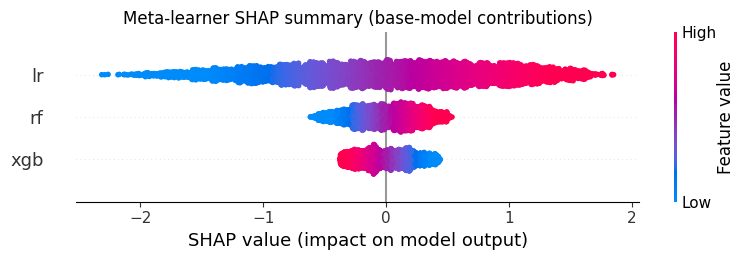

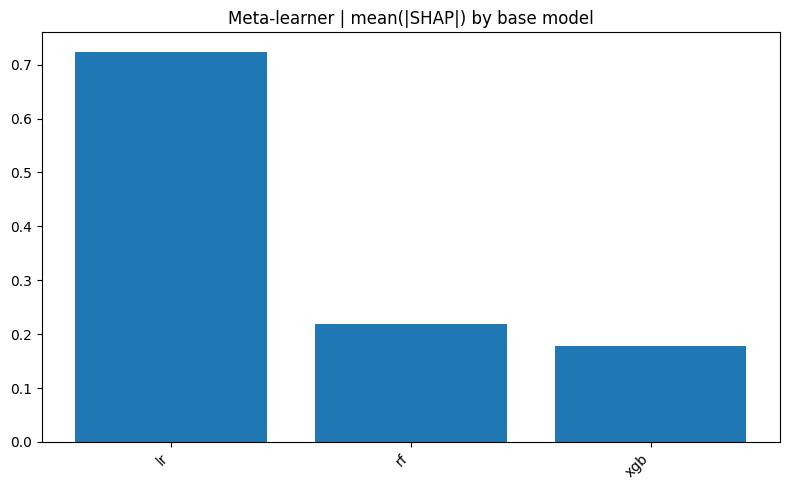

/var/folders/vc/9pky90h50tjdhdw9xnj_zsbc0000gn/T/ipykernel_53707/3167265464.py:250: UserWarning: TreeExplainer failed (ValueError: could not convert string to float: '[5.995554E-1]'). Falling back to model-agnostic KernelExplainer (slower).
  warnings.warn(f"TreeExplainer failed ({type(e).__name__}: {e}). Falling back to model-agnostic KernelExplainer (slower).")
Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



=== SHAP: Feature importance for base model: xgb ===


100%|██████████| 1000/1000 [02:48<00:00,  5.92it/s] 


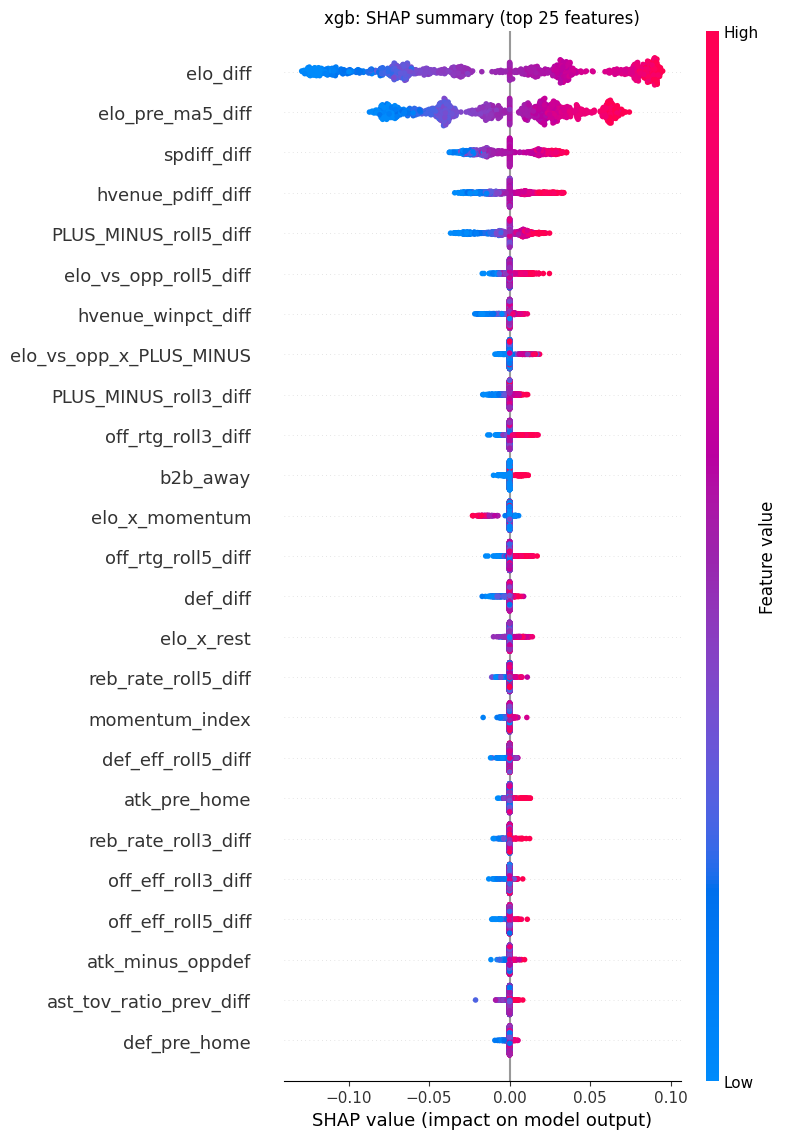


Top-20 features by mean(|SHAP|):
                feature  mean_abs_shap  rank  cum_frac
               elo_diff       0.061570     1  0.372319
       elo_pre_ma5_diff       0.038753     2  0.606664
            spdiff_diff       0.017322     3  0.711411
      hvenue_pdiff_diff       0.011289     4  0.779679
  PLUS_MINUS_roll5_diff       0.010029     5  0.840325
  elo_vs_opp_roll5_diff       0.003430     6  0.861068
     hvenue_winpct_diff       0.003069     7  0.879626
elo_vs_opp_x_PLUS_MINUS       0.002106     8  0.892362
  PLUS_MINUS_roll3_diff       0.001926     9  0.904010
     off_rtg_roll3_diff       0.001506    10  0.913117
               b2b_away       0.001461    11  0.921955
         elo_x_momentum       0.001382    12  0.930309
     off_rtg_roll5_diff       0.001309    13  0.938227
               def_diff       0.001234    14  0.945687
             elo_x_rest       0.001005    15  0.951764
    reb_rate_roll5_diff       0.000496    16  0.954765
         momentum_index       0

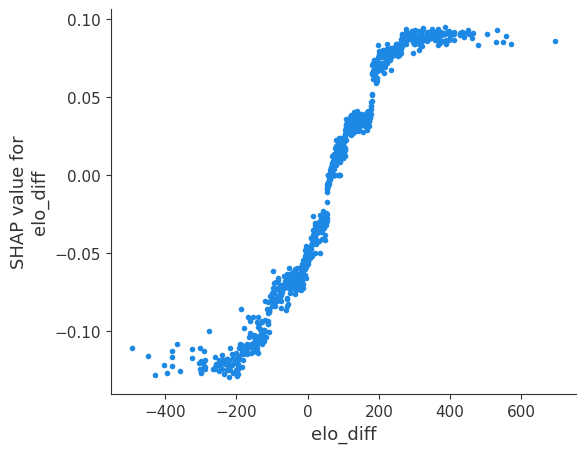

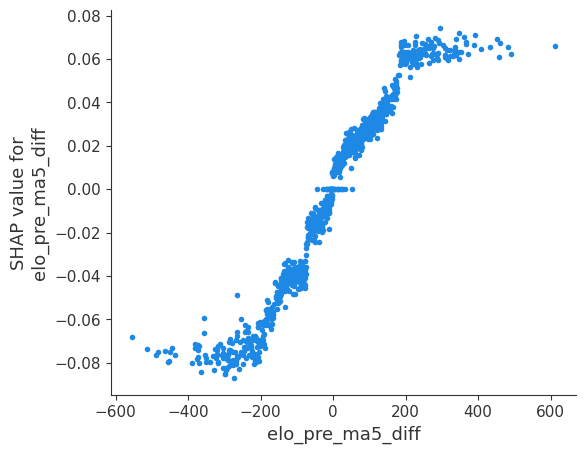

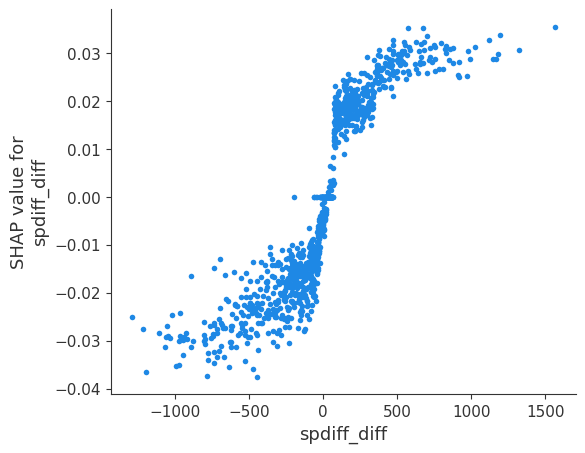

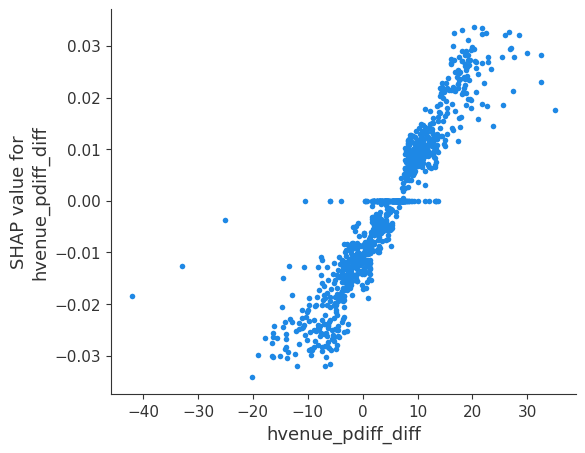

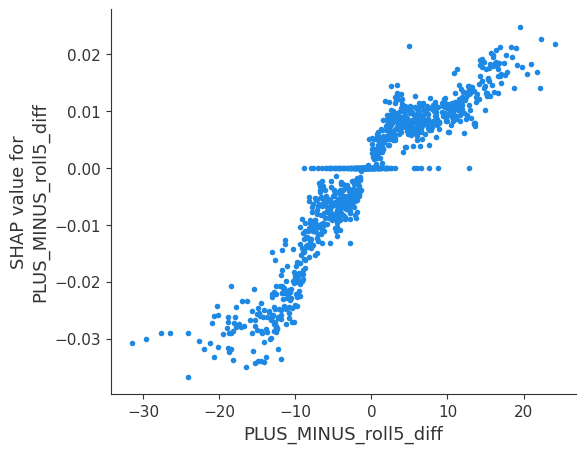

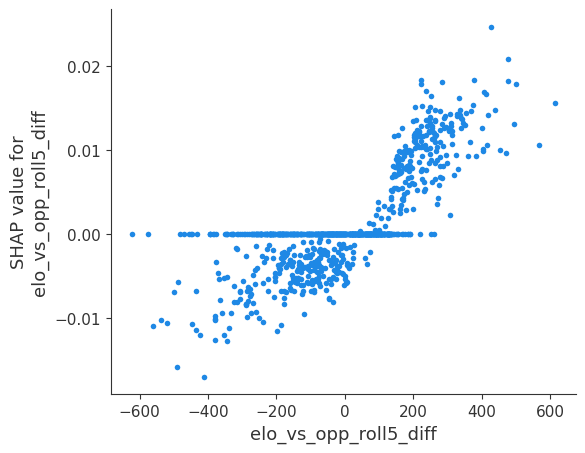

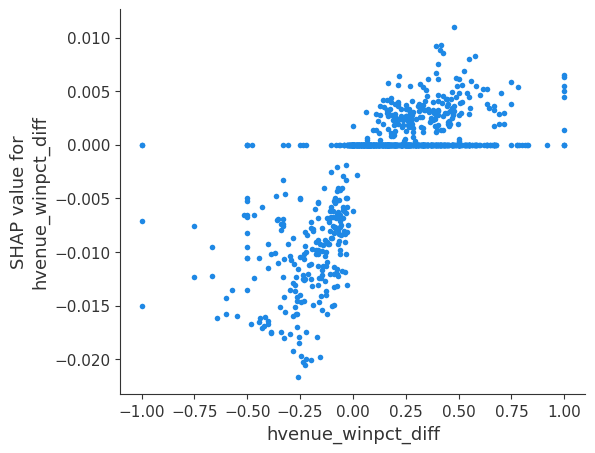

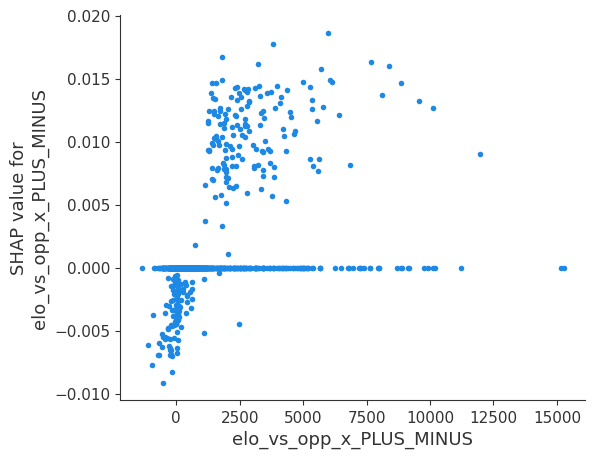

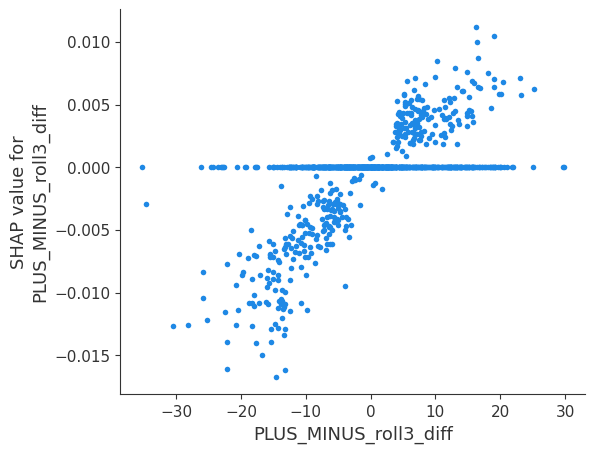

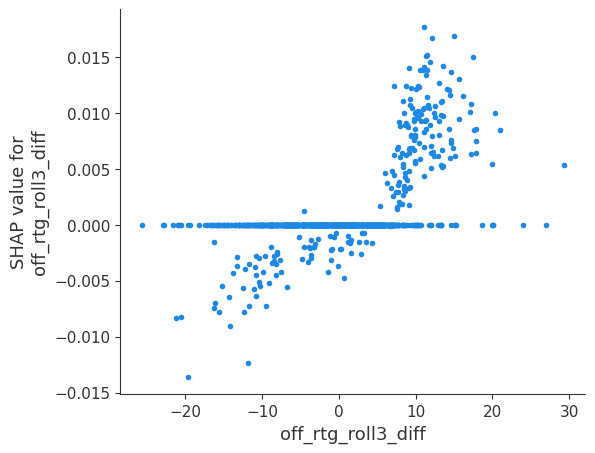

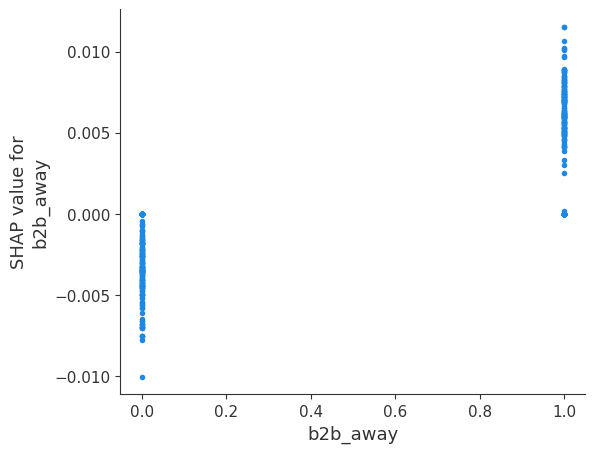

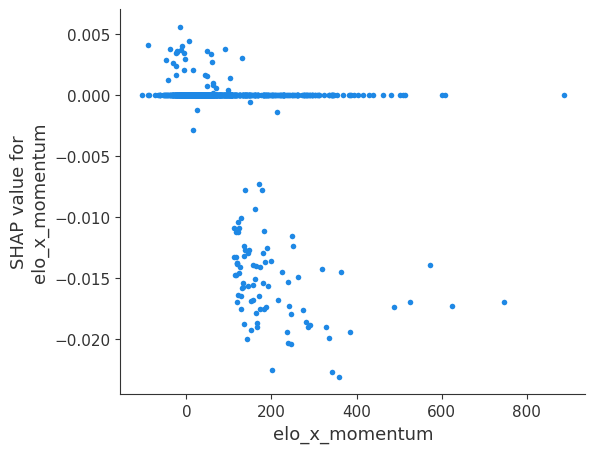

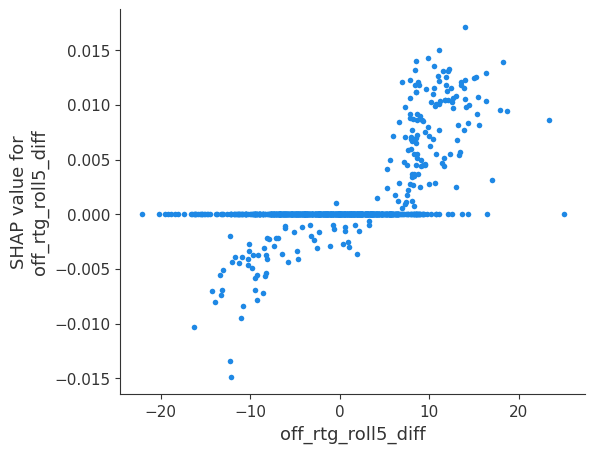

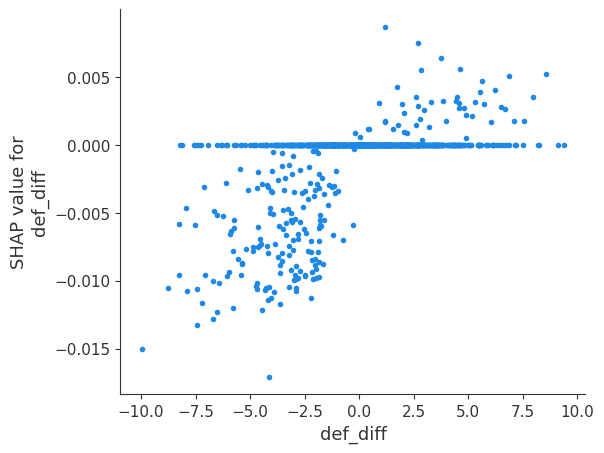

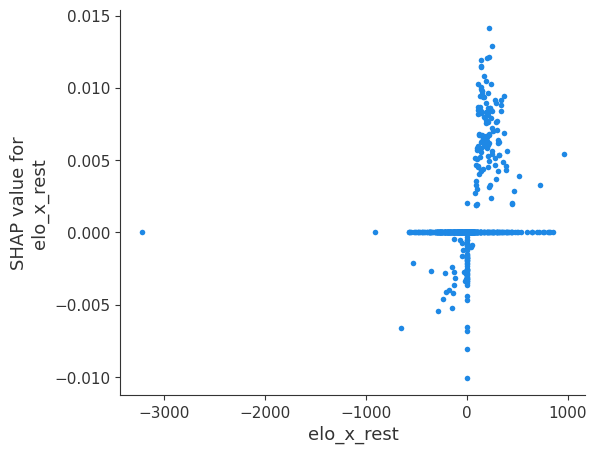

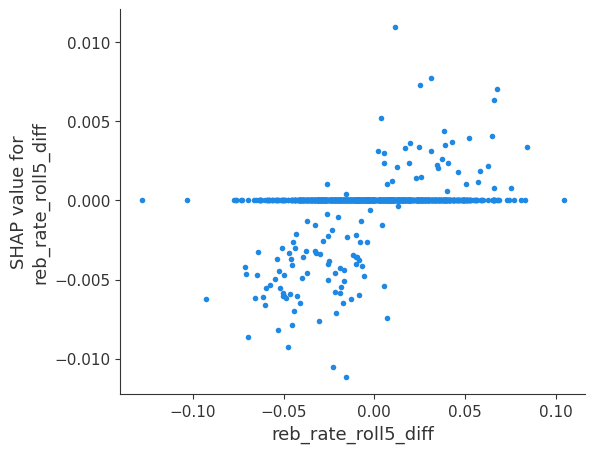

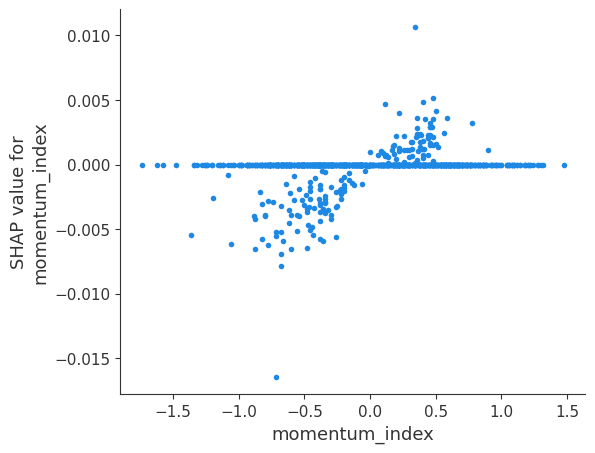

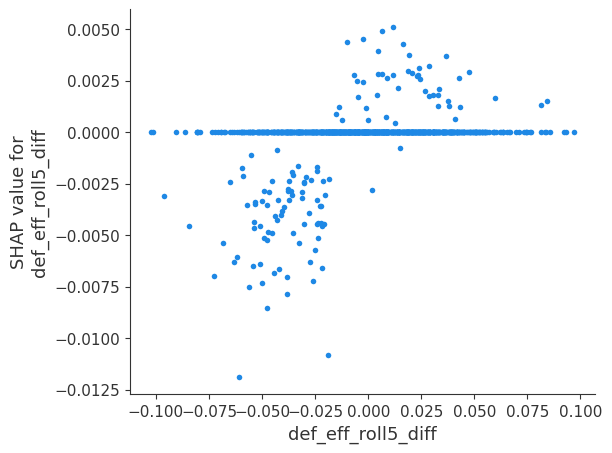

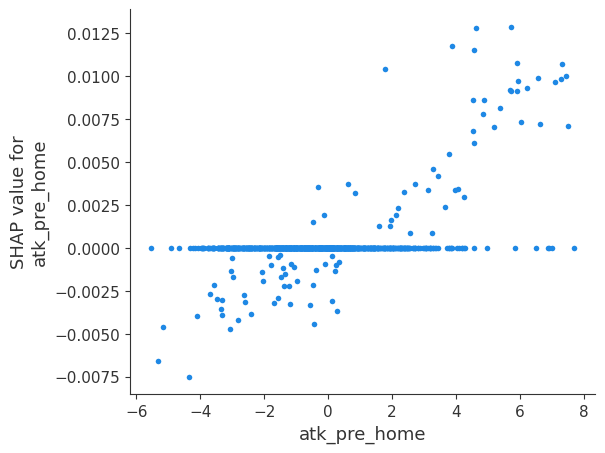

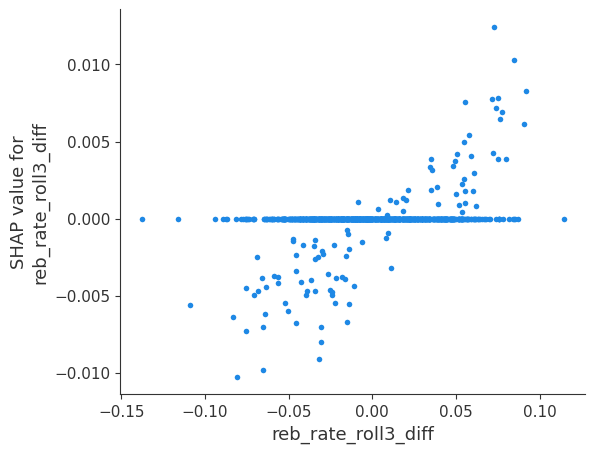

In [ ]:
# %% [markdown]
# === SHAP for Stack + Best Tree (with XGBoost base_score fix) ===

# %%
# 0) Imports (install shap if needed)
try:
    import shap
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "shap"])
    import shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import warnings

# ---------------------------
# Helpers
# ---------------------------
def unwrap_pipeline(pl):
    if isinstance(pl, Pipeline):
        pre = Pipeline(pl.steps[:-1]) if len(pl.steps) > 1 else None
        est = pl.steps[-1][1]
        return pre, est
    return None, pl

def get_meta_Z_and_names(stack_model, X_df, feat_names):
    base_names = [name for name, _ in stack_model.base_fitted_]
    cols = [est.predict_proba(np.asarray(X_df))[:, 1] for _, est in stack_model.base_fitted_]
    Z = np.column_stack(cols)
    names = base_names[:]
    if getattr(stack_model, "passthrough_idx", None):
        pidx = stack_model.passthrough_idx
        if pidx is not None and len(pidx):
            Z = np.hstack([Z, np.asarray(X_df)[:, pidx]])
            names += [feat_names[i] for i in pidx]
    return Z, names

def pick_best_tree_base(stack_model):
    priority = ["xgb", "lgb_dart", "catboost", "rf", "gb"]
    d = {name: est for name, est in stack_model.base_fitted_}
    for key in priority:
        if key in d:
            return key, d[key]
    for name, est in stack_model.base_fitted_:
        if any(k in name.lower() for k in ["xgb", "lgb", "cat", "forest", "boost"]):
            return name, est
    return None, None

def to_2d_frame(X_like, cols=None):
    if isinstance(X_like, pd.DataFrame):
        return X_like, list(X_like.columns)
    X_arr = np.asarray(X_like)
    if cols is None:
        cols = [f"f{i}" for i in range(X_arr.shape[1])]
    return pd.DataFrame(X_arr, columns=cols), cols

def mean_abs_shap_per_feature(shap_vals):
    """
    Return a 1-D vector (n_features,) of mean absolute SHAP.
    Handles:
      - array of shape (n_samples, n_features)
      - list of arrays, length n_classes, each (n_samples, n_features)
      - array of shape (n_samples, n_features, n_classes)
    """
    if isinstance(shap_vals, list):
        # list of (N, F) -> stack to (C, N, F)
        arr = np.stack([np.asarray(v) for v in shap_vals], axis=0)
        return np.mean(np.abs(arr), axis=(0, 1))      # -> (F,)
    arr = np.asarray(shap_vals)
    if arr.ndim == 3 and arr.shape[-1] > 1:          # (N, F, C)
        return np.mean(np.abs(arr), axis=(0, 2))     # -> (F,)
    # normal binary/regression: (N, F)
    return np.mean(np.abs(arr), axis=0)  

def get_out_feature_names(preprocessor, in_cols, X_transformed):
    """
    Try hard to get names after the preprocessor. Fall back to in_cols if the
    width matches; otherwise generate generic names.
    """
    # 1) Try sklearn API
    try:
        return list(preprocessor.get_feature_names_out(in_cols))
    except Exception:
        try:
            return list(preprocessor.get_feature_names_out())
        except Exception:
            pass

    # 2) If dims unchanged, reuse original names
    if X_transformed.shape[1] == len(in_cols):
        return list(in_cols)

    # 3) Otherwise, make generic names
    return [f"t{i}" for i in range(X_transformed.shape[1])]

def shap_values_2d_for_plot(sv):
    """
    Produce a 2-D SHAP array for dependence plots:
      - list of (N,F): pick class 1 if available else class 0
      - (N,F,C): take class 1 if available else mean across classes
      - (N,F): return as-is
    """
    if isinstance(sv, list):
        return np.asarray(sv[1 if len(sv) > 1 else 0])
    arr = np.asarray(sv)
    if arr.ndim == 3 and arr.shape[-1] > 1:
        # prefer class 1, else average
        return arr[:, :, 1] if arr.shape[-1] > 1 else np.mean(arr, axis=2)
    return arr


def _build_keep_list_from_shap(mean_abs_shap: np.ndarray, feature_names, cum_importance=0.95, min_keep=20):
    """
    Create a keep-list using a cumulative-importance rule with a floor of min_keep.
    Returns: features_to_keep (list), features_to_drop (list), importance_df (pd.DataFrame)
    """
    imp = np.ravel(np.asarray(mean_abs_shap, dtype=float))
    # guard if all zeros (rare but possible)
    if not np.isfinite(imp).any() or np.allclose(imp, 0):
        importance_df = pd.DataFrame({
            "feature": feature_names,
            "mean_abs_shap": imp,
            "rank": np.arange(1, len(feature_names) + 1),
            "cum_frac": np.linspace(0, 1, len(feature_names), endpoint=True)
        }).sort_values("rank")
        # keep at least min_keep in this degenerate case
        order = np.argsort(imp)[::-1]
        keep_idx = order[:min_keep]
        keep = [feature_names[i] for i in keep_idx]
        drop = [f for f in feature_names if f not in keep]
        return keep, drop, importance_df

    order = np.argsort(imp)[::-1]
    imp_sorted = imp[order]
    names_sorted = np.array(feature_names)[order]
    cum = np.cumsum(imp_sorted)
    cum_frac = cum / cum[-1]

    # position where cumulative exceeds threshold
    k_star = np.searchsorted(cum_frac, cum_importance) + 1
    k = max(min_keep, k_star)
    k = min(k, len(names_sorted))

    keep = list(names_sorted[:k])
    drop = list(names_sorted[k:])

    importance_df = pd.DataFrame({
        "feature": names_sorted,
        "mean_abs_shap": imp_sorted,
        "rank": np.arange(1, len(names_sorted) + 1),
        "cum_frac": cum_frac
    })
    return keep, drop, importance_df

# ---------------------------
# User-tunable selector knobs
# ---------------------------
CUM_IMPORTANCE = 0.95   # keep features until 95% of total mean(|SHAP|)
MIN_KEEP       = 20     # never keep fewer than this

# Choose split to explain
X_explain = X_va  # or X_te
y_explain = y_va

# Background subsamples (speed)
rng = np.random.default_rng(42)
bg_n_meta  = min(1000, len(X_explain))
bg_n_feat  = min(1000, len(X_explain))
idx_meta_bg = rng.choice(len(X_explain), size=bg_n_meta, replace=False)
idx_feat_bg = rng.choice(len(X_explain), size=bg_n_feat, replace=False)

# ---------------------------
# 1) SHAP for the META-LEARNER
# ---------------------------
print("=== SHAP: Meta-learner (base-model contributions) ===")
Z_all, Z_names = get_meta_Z_and_names(model, X_explain, FEATS)
Z_bg  = Z_all[idx_meta_bg]

pre_meta, est_meta = unwrap_pipeline(model.meta_)
Z_tr_bg  = pre_meta.transform(Z_bg)  if pre_meta is not None else Z_bg
Z_tr_all = pre_meta.transform(Z_all) if pre_meta is not None else Z_all

meta_explainer = shap.LinearExplainer(est_meta, Z_tr_bg)
meta_shap_vals = meta_explainer.shap_values(Z_tr_all)

Z_df, Z_cols = to_2d_frame(Z_all, Z_names)
plt.figure(figsize=(8, 6))
shap.summary_plot(meta_shap_vals, Z_df, feature_names=Z_cols, show=False)
plt.title("Meta-learner SHAP summary (base-model contributions)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8, 5))
mean_abs = np.abs(meta_shap_vals).mean(axis=0)
order = np.argsort(mean_abs)[::-1]
plt.bar(np.array(Z_cols)[order], mean_abs[order])
plt.xticks(rotation=45, ha='right')
plt.title("Meta-learner | mean(|SHAP|) by base model")
plt.tight_layout(); plt.show()

# ---------------------------
# 2) SHAP for the BEST TREE BASE (with XGB fix) + keep-list
# ---------------------------
best_name, best_tree = pick_best_tree_base(model)
FEATURES_TO_KEEP, FEATURES_TO_DROP, SHAP_FEATURE_IMPORTANCE = [], [], pd.DataFrame()

if best_tree is None:
    print("\n(No tree-like base model found — skipping feature-level SHAP.)")
else:
    print(f"\n=== SHAP: Feature importance for base model: {best_name} ===")

    pre_b, est_b = unwrap_pipeline(best_tree)

    # Prepare features exactly as trained
    X_feat = X_explain.reindex(columns=FEATS)
    X_feat_bg = X_feat.iloc[idx_feat_bg]

    Xe = pre_b.transform(X_feat)    if pre_b is not None else X_feat
    Xb = pre_b.transform(X_feat_bg) if pre_b is not None else X_feat_bg
    Xe = np.asarray(Xe, dtype=np.float32)  # SHAP/XGB are happier with float32
    Xb = np.asarray(Xb, dtype=np.float32)

    # Build TreeExplainer robustly across libs
    tree_explainer = None
    tree_shap_vals = None

    out_cols = get_out_feature_names(pre_b, list(X_feat.columns), Xe)
    Xe_df = pd.DataFrame(Xe[:Xe.shape[0]], columns=out_cols)

    try:
        # Special handling for XGBoost >= 2.0 (base_score sometimes stored as a string)
        import xgboost as xgb
        if isinstance(est_b, xgb.XGBModel):
            booster = est_b.get_booster()
            bs = booster.attr("base_score")
            # Coerce string base_score to float string; ignore if already fine
            try:
                booster.set_attr(base_score=str(float(bs)))
            except Exception:
                pass
            tree_explainer = shap.TreeExplainer(booster, data=Xb, model_output="probability")
            tree_shap_vals = tree_explainer.shap_values(Xe, check_additivity=False)
        else:
            # LightGBM / CatBoost / sklearn-GB / RF
            tree_explainer = shap.TreeExplainer(est_b, data=Xb, model_output="probability")
            tree_shap_vals = tree_explainer.shap_values(Xe, check_additivity=False)
    except Exception as e:
        warnings.warn(f"TreeExplainer failed ({type(e).__name__}: {e}). Falling back to model-agnostic KernelExplainer (slower).")
        # Conservative fallback: small background for speed
        f = lambda z: best_tree.predict_proba(z)[:, 1]
        kern = shap.KernelExplainer(f, Xb[:200])
        tree_shap_vals = kern.shap_values(Xe[:1000], nsamples=200)  # cap for runtime
        Xe = Xe[:1000]  # match above

    # Plot
    Xe_df, Xe_cols = to_2d_frame(X_feat.iloc[:Xe.shape[0]], list(X_feat.columns))
    plt.figure(figsize=(9, 7))
    shap.summary_plot(tree_shap_vals, Xe_df, feature_names=Xe_cols, show=False, max_display=25)
    plt.title(f"{best_name}: SHAP summary (top 25 features)")
    plt.tight_layout(); plt.show()

    # ---- NEW: compute keep-list from SHAP ----
    mean_abs_tree = mean_abs_shap_per_feature(tree_shap_vals)   # <-- 1-D (n_features,)
    FEATURES_TO_KEEP, FEATURES_TO_DROP, SHAP_FEATURE_IMPORTANCE = _build_keep_list_from_shap(
        mean_abs_tree, Xe_cols, cum_importance=CUM_IMPORTANCE, min_keep=MIN_KEEP
    )

    # Tidy importance table (unsorted original order is fine; we provide sorted too)
    SHAP_FEATURE_IMPORTANCE = SHAP_FEATURE_IMPORTANCE  # already sorted by rank desc-importance

    # Display a compact preview
    print("\nTop-20 features by mean(|SHAP|):")
    print(SHAP_FEATURE_IMPORTANCE.head(20).to_string(index=False))

    print(f"\nSelected {len(FEATURES_TO_KEEP)} features (CUM_IMPORTANCE={CUM_IMPORTANCE}, MIN_KEEP={MIN_KEEP}).")
    print("FEATURES_TO_KEEP (first 30):", FEATURES_TO_KEEP[:30])
    print(f"Features to drop (noisy/low-utility): {len(FEATURES_TO_DROP)}")

    tree_shap_vals_2d = shap_values_2d_for_plot(tree_shap_vals)

    # Optional: handy per-feature dependence plots for a few keys you care about
    for key in FEATURES_TO_KEEP:
        if key in Xe_cols:
            shap.dependence_plot(key, tree_shap_vals_2d, Xe_df, feature_names=Xe_cols, interaction_index=None)

# After this runs, you have:
# - SHAP_FEATURE_IMPORTANCE: DataFrame with columns [feature, mean_abs_shap, rank, cum_frac]
# - FEATURES_TO_KEEP: list[str]
# - FEATURES_TO_DROP: list[str]


In [58]:
# === Safe, single-cell calibration utilities (pickle/cloudpickle friendly) ===
import numpy as np
import inspect
from sklearn.base import clone
from sklearn.metrics import brier_score_loss, log_loss
from scipy.optimize import minimize
import joblib as jl
import cloudpickle as cp

EPS = 1e-6
def _clip(p):  return np.clip(np.asarray(p, float), EPS, 1 - EPS)
def _logit(p): p = _clip(p); return np.log(p/(1-p))

def beta_fit_regularized(p, y, lam=1e-3):
    p = _clip(p); y = np.asarray(y, float); lg = _logit(p)
    def obj(theta):
        A,B,C = theta
        z = A*lg + B*np.log(1-p) + C
        q = 1/(1+np.exp(-z))
        return np.mean((q - y)**2) + lam*(A*A + B*B + C*C)
    A,B,C = minimize(obj, x0=[1.0,0.0,0.0], method="L-BFGS-B").x
    return [float(A), float(B), float(C)]

def beta_apply(p, theta):
    p = _clip(p)
    z = theta[0]*_logit(p) + theta[1]*np.log(1-p) + theta[2]
    return _clip(1/(1+np.exp(-z)))

def _fit_maybe_groups(est, Xtr, ytr, groups_tr=None):
    """Call est.fit(...), passing groups if the estimator accepts it."""
    try:
        sig = inspect.signature(est.fit)
        if "groups" in sig.parameters and groups_tr is not None:
            return est.fit(Xtr, ytr, groups=groups_tr)
        else:
            return est.fit(Xtr, ytr)
    except TypeError:
        # fallback in case signature inspection misfires (e.g., cythonized)
        try:
            return est.fit(Xtr, ytr, groups=groups_tr)
        except TypeError:
            return est.fit(Xtr, ytr)

def oof_predict_proba(estimator, X, y, splitter, groups, return_mask=False):
    is_df = hasattr(X, "iloc")
    n = len(X)
    p_oof = np.full(n, np.nan, dtype=float)
    mask  = np.zeros(n, dtype=bool)

    y_arr = np.asarray(y).ravel()
    groups_arr = np.asarray(groups).ravel()

    for tr, va in splitter.split(X, y, groups_arr):
        if len(tr) == 0 or len(va) == 0:
            continue
        e = clone(estimator)
        if is_df:
            _fit_maybe_groups(e, X.iloc[tr], y_arr[tr], groups_tr=groups_arr[tr])
            p = e.predict_proba(X.iloc[va])[:, 1]
        else:
            Xn = np.asarray(X)
            _fit_maybe_groups(e, Xn[tr], y_arr[tr], groups_tr=groups_arr[tr])
            p = e.predict_proba(Xn[va])[:, 1]
        p_oof[va] = p
        mask[va] = True

    return (p_oof, mask) if return_mask else p_oof

def train_calibrated_model(
    estimator, X, y, groups, splitter=None, reg_lambda=1e-3,
    bundle_path=None, use_cloudpickle=True,
):
    # keep X as DF/array; just flatten y/groups
    y_arr = np.asarray(y).ravel()
    groups_arr = np.asarray(groups).ravel()

    if splitter is None:
        splitter = PurgedGroupTimeSeriesSplit(n_splits=6, group_gap=1)

    p_oof, mask = oof_predict_proba(estimator, X, y_arr, splitter, groups_arr, return_mask=True)
    p_fit, y_fit = p_oof[mask], y_arr[mask]

    theta = beta_fit_regularized(p_fit, y_fit, lam=reg_lambda)

    # final fit on all data – pass groups if supported
    e_final = clone(estimator)
    if hasattr(X, "iloc"):
        _fit_maybe_groups(e_final, X, y_arr, groups_tr=groups_arr)
    else:
        _fit_maybe_groups(e_final, np.asarray(X), y_arr, groups_tr=groups_arr)

    diag = {
        "oof_cov": int(mask.sum()),
        "n": int(len(y_arr)),
        "oof_brier_uncal": float(brier_score_loss(y_fit, p_fit)),
        "oof_brier_cal":   float(brier_score_loss(y_fit, beta_apply(p_fit, theta))),
        "oof_logloss_uncal": float(log_loss(y_fit, p_fit)),
        "oof_logloss_cal":   float(log_loss(y_fit, beta_apply(p_fit, theta))),
    }
    return e_final, theta, diag


def load_bundle(path, use_cloudpickle=True):
    if use_cloudpickle:
        import cloudpickle as cp
        with open(path, "rb") as f:
            obj = cp.load(f)
    else:
        obj = jl.load(path)
    # fix: your previous version looked for obj["calibration"]["theta"]
    return obj["model"], obj["theta"]

def predict_calibrated(model, theta, X_new):
    p_raw = model.predict_proba(np.asarray(X_new))[:, 1]
    return beta_apply(p_raw, theta)


In [59]:
import numpy as np
from sklearn.metrics import brier_score_loss

trval_idx = np.r_[idx_tr, idx_va]
order_trval = np.argsort(games_f.reset_index(drop=True).loc[trval_idx, "date"])

X_trval  = X.iloc[trval_idx].iloc[order_trval].reset_index(drop=True)
y_trval  = y.iloc[trval_idx].iloc[order_trval].reset_index(drop=True)
groups_trval = pd.Series(date_groups).iloc[trval_idx].iloc[order_trval].reset_index(drop=True).to_numpy()


splitter = PurgedGroupTimeSeriesSplit(n_splits=6, group_gap=1)                              
final_model, theta, diag = train_calibrated_model(model, X_trval, y_trval, groups_trval,
     splitter=splitter,
     reg_lambda=1e-3)

p_te = final_model.predict_proba(X_te)[:,1]
p_cal_te = beta_apply(p_te, theta)
print("TEST Uncal logloss:", log_loss(y_te, p_te), "| Brier:", brier_score_loss(y_te, p_te))
print("TEST Calib logloss:", log_loss(y_te, p_cal_te),   "| Brier:", brier_score_loss(y_te, p_cal_te))
print("TEST AUC (uncal|cal):", roc_auc_score(y_te, p_te), roc_auc_score(y_te, p_cal_te))

TEST Uncal logloss: 0.6213240165119859 | Brier: 0.21603083029221157
TEST Calib logloss: 0.6203048174154072 | Brier: 0.2155916511769848
TEST AUC (uncal|cal): 0.7056344092797093 0.7056344092797093


BEST FEATURES:
TEST Uncal logloss: 0.6210993962344102 | Brier: 0.21589873950170066
TEST Calib logloss: 0.6204495733744266 | Brier: 0.21561917575287454
TEST AUC (uncal|cal): 0.7063462212261692 0.7063462212261692

In [ ]:
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    binids = np.digitize(y_prob, bins) - 1
    ece = 0
    for i in range(n_bins):
        mask = binids == i
        if np.any(mask):
            acc = y_true[mask].mean()
            conf = y_prob[mask].mean()
            ece += abs(acc - conf) * mask.mean()
    return ece
ece = expected_calibration_error(y_te, p_te)
print("ECE:", ece)

ECE: 0.024093880585490484


In [60]:
"""
Final Model Evaluation
"""

from sklearn.metrics import (
    log_loss, brier_score_loss, roc_auc_score, accuracy_score, confusion_matrix
)

def evaluate_model_on_test(model, X_te, y_te, threshold=0.5, n_bins=10):

    p = model.predict_proba(X_te)[:, 1]
    p = beta_apply(p, theta)

    yhat = (p >= threshold).astype(int)

    metrics = {
        "log_loss": float(log_loss(y_te, p)),
        "brier": float(brier_score_loss(y_te, p)),
        "roc_auc": float(roc_auc_score(y_te, p)),
        f"accuracy@{threshold}": float(accuracy_score(y_te, yhat)),
    }

    tn, fp, fn, tp = confusion_matrix(y_te, yhat).ravel()
    metrics.update({"TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn)})

    bins = pd.qcut(p, q=n_bins, duplicates="drop")
    cal_table = (
        pd.DataFrame({"p": p, "y": y_te, "bin": bins})
          .groupby("bin", observed=True)
          .agg(p_mean=("p", "mean"), y_rate=("y", "mean"), n=("y", "size"))
          .reset_index(drop=True)
    )
    cal_table["abs_err"] = (cal_table["p_mean"] - cal_table["y_rate"]).abs()
    metrics[f"calibration_mae({n_bins}-bins)"] = float(
        np.average(cal_table["abs_err"], weights=cal_table["n"])
    )

    return metrics, cal_table

metrics, cal_table = evaluate_model_on_test(model, X_te, y_te, threshold=0.50, n_bins=10)
print(metrics)
cal_table

{'log_loss': 0.6212897070083115, 'brier': 0.21603327148995488, 'roc_auc': 0.7048491102044245, 'accuracy@0.5': 0.6548433561397191, 'TP': 2377, 'FP': 1210, 'TN': 1260, 'FN': 707, 'calibration_mae(10-bins)': 0.020801635964707674}


,p_mean,y_rate,n,abs_err
0,0.255262,0.228417,556,0.026845
1,0.351591,0.347748,555,0.003843
2,0.427395,0.441441,555,0.014046
3,0.496687,0.500000,556,0.003313
4,0.558847,0.549550,555,0.009298
5,0.614546,0.565766,555,0.048781
6,0.669318,0.638489,556,0.030829
7,0.725163,0.690090,555,0.035073
8,0.781321,0.765766,555,0.015556
9,0.845976,0.825540,556,0.020436


BEST FEATURES:
{'log_loss': 0.6215053968956248, 'brier': 0.21607116809439275, 'roc_auc': 0.7055261809230668, 'accuracy@0.5': 0.6527927927927928, 'TP': 2357, 'FP': 1211, 'TN': 1266, 'FN': 716, 'calibration_mae(10-bins)': 0.020722805353712886}
p_mean	y_rate	n	abs_err
0	0.263493	0.225225	555	0.038268
1	0.355305	0.351351	555	0.003953
2	0.428487	0.427027	555	0.001460
3	0.494653	0.500901	555	0.006248
4	0.554672	0.547748	555	0.006925
5	0.610074	0.565766	555	0.044308
6	0.665194	0.641441	555	0.023753
7	0.723710	0.677477	555	0.046233
8	0.785237	0.771171	555	0.014065
9	0.850844	0.828829	555	0.022016


Text(0.5, 1.0, 'Reliability Diagram')

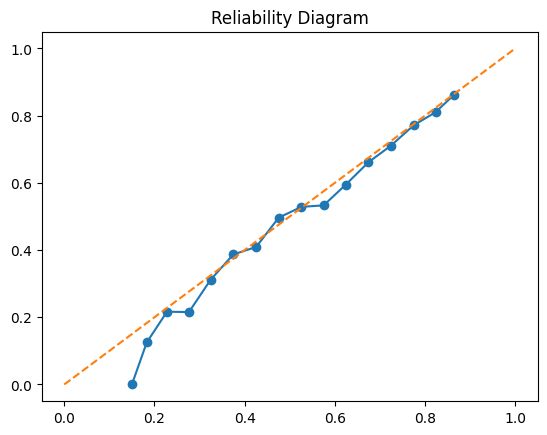

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_te, p_cal_te, n_bins=20)
plt.plot(prob_pred, prob_true, 'o-')
plt.plot([0,1],[0,1],'--')
plt.title('Reliability Diagram')

In [152]:
"""
Backtesting strategy
"""

sportsdata_api_key = '8938f36f9c0f4abcb11b11498ca08860'
games_bt = games_f[pd.to_datetime(games_f["date"]) >= pd.Timestamp("2023-10-01")].reset_index(drop=True)

TEAM_ALIASES = {
    "NY": "NYK", "GS": "GSW", "NO": "NOP", "UTAH": "UTA", "PHO": "PHX", "SA": "SAS",
    # historical oddities (just in case)
    "NJN": "BKN", "CHA": "CHA", "WSH": "WAS", "UTH": "UTA"
}

import time, warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

from dataclasses import dataclass
from typing import Optional, Tuple, List, Dict

import numpy as np
import pandas as pd
import requests

# ---------- Config ----------
@dataclass
class BacktestConfig:
    ev_threshold: float = 0.00          # per-unit EV gate to place bets
    kelly_fraction_scale: float = 0.10  # 1/10 Kelly
    kelly_cap: float = 0.03             # <= 3% of bankroll per bet
    min_prob: float = 0.0               # optional min model prob for chosen side
    sleep_between_calls: float = 0      # seconds (API politeness)
    starting_bankroll: float = 100.0    # starting units
    target_books: Optional[set] = frozenset({"Pinnacle"})  # set[str] or None for all
    unit_fraction_of_bankroll: float = 0.01  # 1% of starting roll = 1 unit by default
    unit_size_override: Optional[float] = None  # set explicit unit size (e.g., $25) if desired

cfg = BacktestConfig()

# ---------- helpers ----------
def _to_date_str(x) -> str:
    if isinstance(x, str): return x[:10]
    return pd.to_datetime(x).strftime("%Y-%m-%d")

def norm_team(x: str) -> str:
    if x is None: return x
    x = str(x).strip().upper()
    return TEAM_ALIASES.get(x, x)

def american_to_decimal(ml: Optional[float]) -> Optional[float]:
    if ml is None or (isinstance(ml, float) and np.isnan(ml)): return None
    try: ml = float(ml)
    except Exception: return None
    if ml > 0: return 1.0 + ml/100.0
    if ml < 0: return 1.0 + 100.0/abs(ml)
    return None

def implied_probability(ml: Optional[float]) -> Optional[float]:
    d = american_to_decimal(ml)
    if d is None or d == 0: return None
    return 1.0 / d

def kelly_fraction(p: float, ml: Optional[float]) -> float:
    d = american_to_decimal(ml)
    if d is None: return 0.0
    b = d - 1.0
    f = (b*p - (1.0 - p)) / b
    return float(max(0.0, f))

def ev_per_unit(p: float, ml: Optional[float]) -> float:
    d = american_to_decimal(ml)
    if d is None: return np.nan
    return p*(d-1.0) - (1-p)

def normalize_moneyline(x):
    # null/parse-safe + “cents” fix
    if x is None or (isinstance(x, float) and np.isnan(x)): return None
    try:
        x = int(x)
    except Exception:
        return None
    if -99 <= x < 0:   return x - 100   # -52 -> -152
    if 0   < x < 100: return x + 100   #  44 -> +144
    return x

def make_feature_matrix(games_df: pd.DataFrame,
                        exclude: Tuple[str,...] = ('sid','date','team_home','team_away','win_home',
                                                   'HomeTeam','AwayTeam','HomeML','AwayML','books',
                                                   'home_ml','away_ml')) -> Tuple[pd.DataFrame, List[str]]:
    cols = [c for c in games_df.columns if c not in exclude and pd.api.types.is_numeric_dtype(games_df[c])]
    return games_df[cols].copy(), cols

def worst_moneyline(values):
    ser = pd.Series(values).dropna().apply(normalize_moneyline)
    if ser.empty:
        return np.nan
    return ser.min()

# ---------- Odds fetch/aggregate (worst pregame price per game) ----------
def collapse_and_aggregate(rows: list[dict], target_books: Optional[set]) -> pd.DataFrame:
    if not rows:
        return pd.DataFrame(columns=["date","HomeTeam","AwayTeam","HomeML","AwayML","books"])

    df = pd.DataFrame(rows)
    df["HomeTeam"] = df["HomeTeam"].map(norm_team)
    df["AwayTeam"] = df["AwayTeam"].map(norm_team)
    df["date"]     = pd.to_datetime(df["date"]).dt.strftime("%Y-%m-%d")
    df["Updated"]  = pd.to_datetime(df["Updated"], errors="coerce")

    # filter to target sportsbook(s) if provided
    if target_books:
        df = df[df["Bookmaker"].isin(target_books)].copy()
        if df.empty:
            # fallback: if preferred book missing, keep earliest from any book
            target_books = None
            df = pd.DataFrame(rows)
            df["HomeTeam"] = df["HomeTeam"].map(norm_team)
            df["AwayTeam"] = df["AwayTeam"].map(norm_team)
            df["date"]     = pd.to_datetime(df["date"]).dt.strftime("%Y-%m-%d")
            df["Updated"]  = pd.to_datetime(df["Updated"], errors="coerce")

    # worst quote per (game, book)
    df = df.sort_values(["GameId","Bookmaker","Updated"])

    # select the worst (lowest payout) price across the remaining books
    per_game = (df.groupby(["date","HomeTeam","AwayTeam"], as_index=False)
                  .agg(
                      HomeML=("HomeMoneyLine", worst_moneyline),
                      AwayML=("AwayMoneyLine", worst_moneyline),
                      books =("Bookmaker","nunique")
                  ))


    for c in ["HomeML","AwayML"]:
        per_game[c] = per_game[c].apply(normalize_moneyline)

    return per_game

def fetch_moneylines_by_date(date: str, api_key: str, target_books: Optional[set]) -> pd.DataFrame:
    url = f"https://api.sportsdata.io/v3/nba/odds/json/GameOddsByDate/{date}?key={api_key}"
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    data = r.json()

    rows = []
    for g in data or []:
        home = g.get("HomeTeamName") or g.get("HomeTeam")
        away = g.get("AwayTeamName") or g.get("AwayTeam")
        gid  = g.get("GameID") or g.get("GameId")
        for o in g.get("PregameOdds") or []:
            if o.get("OddType") and o["OddType"] != "pregame":
                continue
            rows.append({
                "date": date,
                "HomeTeam": home,
                "AwayTeam": away,
                "GameId": gid,
                "Bookmaker": o.get("Sportsbook") or o.get("SportsbookId"),
                "HomeMoneyLine": o.get("HomeMoneyLine"),
                "AwayMoneyLine": o.get("AwayMoneyLine"),
                "Updated": o.get("Updated") or o.get("Created"),
            })
    return collapse_and_aggregate(rows, target_books)

# ---------- Backtest loop ----------
def backtest_daily(games: pd.DataFrame, model, api_key: str, cfg: BacktestConfig = cfg):
    g = games.copy()
    g["date"] = g["date"].apply(_to_date_str)

    bankroll = cfg.starting_bankroll
    unit_override = getattr(cfg, "unit_size_override", None)
    unit_fraction = getattr(cfg, "unit_fraction_of_bankroll", 0.01)
    if unit_override is not None and unit_override > 0:
        unit_size = unit_override
    else:
        base = cfg.starting_bankroll * unit_fraction if unit_fraction else 0.0
        unit_size = base if base > 0 else 1.0
    all_ledgers, daily_stats = [], []

    for i, d in enumerate(sorted(g["date"].unique())):
        odds = fetch_moneylines_by_date(d, api_key, cfg.target_books)

        # Merge; may be empty if no odds
        day_games = g[g["date"] == d].merge(
            odds, left_on=["date","team_home","team_away"],
            right_on=["date","HomeTeam","AwayTeam"], how="left"
        )

        # pick odds columns produced by aggregator
        if not {"HomeML","AwayML"}.issubset(day_games.columns):
            print(f"{d} — no odds available; skipping")
            continue
        day_games["home_ml"] = day_games["HomeML"]
        day_games["away_ml"] = day_games["AwayML"]

        # guardrails: normalized, present
        have_odds = day_games[["home_ml","away_ml"]].notna().all(axis=1)
        if not have_odds.any():
            print(f"{d} — odds missing for all games; skipping")
            continue
        # check normalization (ignore rows without odds)
        if not (day_games.loc[have_odds, ["home_ml","away_ml"]].abs() >= 100).all().all():
            print(day_games)
            raise ValueError(f"{d}: Unnormalized moneylines detected (<100 in magnitude)")

        # Model probabilities
        X, _ = make_feature_matrix(day_games)
        X = X.loc[:, FEATS].copy()

        if hasattr(model, "feature_names_in_"):
            missing = set(model.feature_names_in_) - set(X.columns)
            if missing:
                raise ValueError(f"Missing features at inference: {sorted(missing)}")
            X = X.loc[:, model.feature_names_in_]
            
        p_home = model.predict_proba(np.asarray(X))[:, 1]
        day_games["p_home"] = p_home
        day_games["p_away"] = 1.0 - p_home

        # EV per unit
        day_games["ev_home_unit"] = day_games.apply(lambda r: ev_per_unit(r["p_home"], r["home_ml"]), axis=1)
        day_games["ev_away_unit"] = day_games.apply(lambda r: ev_per_unit(r["p_away"], r["away_ml"]), axis=1)

        # Pick higher EV side
        pick_home = day_games["ev_home_unit"] >= day_games["ev_away_unit"]
        day_games["bet_side"] = np.where(pick_home, day_games["team_home"], day_games["team_away"])
        day_games["picked_side"] = np.where(pick_home, "HOME", "AWAY")
        day_games["picked_ml"]   = np.where(pick_home, day_games["home_ml"], day_games["away_ml"])
        day_games["picked_p"]    = np.where(pick_home, day_games["p_home"], day_games["p_away"])
        day_games["picked_ev_unit"] = np.where(pick_home, day_games["ev_home_unit"], day_games["ev_away_unit"])
        day_games["picked_implied_prob"] = day_games["picked_ml"].apply(implied_probability)

        # Gate by EV + prob
        prob_ok = np.where(day_games["picked_side"]=="HOME", day_games["p_home"]>=cfg.min_prob,
                           day_games["p_away"]>=cfg.min_prob)
        place = (day_games["picked_ev_unit"] >= cfg.ev_threshold) & prob_ok & day_games["picked_ml"].notna()

        day_bankroll_start = bankroll

        # 1/10 Kelly with cap using the day-start bankroll
        stakes, pnls = [], []
        for ridx, row in day_games.iterrows():
            if not place.loc[ridx]:
                stakes.append(0.0); pnls.append(0.0); continue
            f_full = kelly_fraction(row["picked_p"], row["picked_ml"])
            f = min(1.0, max(0.0, cfg.kelly_fraction_scale * f_full))
            stake = min(day_bankroll_start * f, day_bankroll_start * cfg.kelly_cap)

            win = (row["win_home"] == 1) if row["picked_side"]=="HOME" else (row["win_home"] == 0)
            dds = american_to_decimal(row["picked_ml"])
            pnl = (stake * (dds - 1.0)) if (dds is not None and win) else (-stake if stake>0 else 0.0)
            stakes.append(stake); pnls.append(pnl)

        day_games["bet_amount"] = stakes
        day_games["pnl"] = pnls
        day_games["bet_units"] = day_games["bet_amount"] / unit_size
        day_games["pnl_units"] = day_games["pnl"] / unit_size

        day_ledger = day_games.loc[day_games["bet_amount"]>0, [
            "date","team_home","team_away","bet_side","picked_side","picked_p","picked_ml",
            "picked_implied_prob","bet_amount","bet_units","win_home","pnl","pnl_units"
        ]].reset_index(drop=True)

        n_bets = int(day_ledger.shape[0])
        wins = int(((day_ledger["picked_side"]=="HOME") & (day_ledger["win_home"]==1)).sum() +
                   ((day_ledger["picked_side"]=="AWAY") & (day_ledger["win_home"]==0)).sum())
        hitrate = (wins/n_bets) if n_bets>0 else 0.0
        day_pnl = float(day_ledger["pnl"].sum()) if n_bets>0 else 0.0
        avg_stake = float(day_ledger["bet_amount"].mean()) if n_bets>0 else 0.0
        roi = (day_pnl / day_ledger["bet_amount"].sum()) if n_bets>0 and day_ledger["bet_amount"].sum()>0 else 0.0
        bankroll_end = day_bankroll_start + day_pnl
        day_pnl_units = day_pnl / unit_size
        avg_stake_units = avg_stake / unit_size
        bankroll_end_units = bankroll_end / unit_size

        print(f"{d} — bets: {n_bets}, wins: {wins}, hit%: {hitrate:.3f}, "
              f"PnL: {day_pnl_units:+.3f}u, ROI: {roi:.3f}, avg stake: {avg_stake_units:.3f}u, "
              f"bankroll: {bankroll_end_units:.3f}u")

        all_ledgers.append(day_ledger.assign(bankroll_after=bankroll_end,
                                             bankroll_after_units=bankroll_end_units))
        daily_stats.append({
            "date": d, "bets": n_bets, "wins": wins, "hitrate": hitrate,
            "day_pnl_units": day_pnl_units, "roi": roi, "avg_stake_units": avg_stake_units,
            "bankroll_after": bankroll_end, "bankroll_after_units": bankroll_end_units
        })
        bankroll = bankroll_end

        if i < len(g["date"].unique())-1:
            time.sleep(cfg.sleep_between_calls)

    ledger = pd.concat(all_ledgers, ignore_index=True) if all_ledgers else pd.DataFrame()
    daily  = pd.DataFrame(daily_stats)

    total_bets = int(ledger.shape[0]) if not ledger.empty else 0
    total_wins = int(((ledger["picked_side"]=="HOME") & (ledger["win_home"]==1)).sum() +
                     ((ledger["picked_side"]=="AWAY") & (ledger["win_home"]==0)).sum()) if total_bets>0 else 0
    hitrate = (total_wins/total_bets) if total_bets>0 else 0.0
    total_pnl = ledger["pnl"].sum() if total_bets>0 else 0.0
    final_bankroll = cfg.starting_bankroll + total_pnl
    total_pnl_units = total_pnl / unit_size
    final_bankroll_units = final_bankroll / unit_size
    summary = {
        "bets": total_bets,
        "wins": total_wins,
        "hitrate": hitrate,
        "final_bankroll": float(final_bankroll),
        "final_bankroll_units": float(final_bankroll_units),
        "units_up": float(total_pnl_units),
        "return_on_bankroll": (final_bankroll - cfg.starting_bankroll)/cfg.starting_bankroll if cfg.starting_bankroll>0 else 0.0
    }

    return ledger, daily, summary

# ---------- RUN ----------
ledger, daily, summary = backtest_daily(games_bt, model, sportsdata_api_key, cfg)
print("\n=== Overall Summary ===")
print(summary)
display(daily.tail())
display(ledger.head())


2023-10-30 — bets: 2, wins: 0, hit%: 0.000, PnL: -2.968u, ROI: -1.000, avg stake: 1.484u, bankroll: 97.032u
2023-10-31 — bets: 3, wins: 1, hit%: 0.333, PnL: -4.641u, ROI: -0.535, avg stake: 2.893u, bankroll: 92.391u
2023-11-01 — bets: 10, wins: 6, hit%: 0.600, PnL: +3.660u, ROI: 0.252, avg stake: 1.450u, bankroll: 96.051u
2023-11-02 — bets: 3, wins: 2, hit%: 0.667, PnL: +1.663u, ROI: 0.314, avg stake: 1.767u, bankroll: 97.714u
2023-11-03 — bets: 6, wins: 6, hit%: 1.000, PnL: +11.606u, ROI: 1.422, avg stake: 1.361u, bankroll: 109.320u
2023-11-04 — bets: 7, wins: 3, hit%: 0.429, PnL: +8.151u, ROI: 1.083, avg stake: 1.076u, bankroll: 117.471u
2023-11-05 — bets: 5, wins: 0, hit%: 0.000, PnL: -8.938u, ROI: -1.000, avg stake: 1.788u, bankroll: 108.534u
2023-11-06 — bets: 7, wins: 3, hit%: 0.429, PnL: -6.165u, ROI: -0.681, avg stake: 1.294u, bankroll: 102.369u
2023-11-08 — bets: 12, wins: 6, hit%: 0.500, PnL: +19.016u, ROI: 0.955, avg stake: 1.660u, bankroll: 121.385u
2023-11-09 — bets: 1, wi

,date,bets,wins,hitrate,day_pnl_units,roi,avg_stake_units,bankroll_after,bankroll_after_units
316,2025-11-02,6,2,0.333333,-20.948499,-0.426564,8.184985,552.029422,552.029422
317,2025-11-03,6,2,0.333333,25.318427,0.965945,4.368505,577.347850,577.347850
318,2025-11-04,6,2,0.333333,-12.773845,-0.207486,10.260817,564.574005,564.574005
319,2025-11-05,8,1,0.125000,-21.602246,-0.482292,5.598853,542.971759,542.971759
320,2025-11-06,1,0,0.000000,-3.421387,-1.000000,3.421387,539.550373,539.550373


,date,team_home,team_away,bet_side,picked_side,picked_p,picked_ml,picked_implied_prob,bet_amount,bet_units,win_home,pnl,pnl_units,bankroll_after,bankroll_after_units
0,2023-10-30,OKC,DET,DET,AWAY,0.451223,328,0.233645,2.839124,2.839124,1,-2.839124,-2.839124,97.032034,97.032034
1,2023-10-30,DEN,UTA,UTA,AWAY,0.185457,472,0.174825,0.128842,0.128842,1,-0.128842,-0.128842,97.032034,97.032034
2,2023-10-31,PHX,SAS,PHX,HOME,0.862380,-264,0.725275,2.910961,2.910961,0,-2.910961,-2.910961,92.390601,92.390601
3,2023-10-31,LAC,ORL,LAC,HOME,0.793689,-242,0.707602,2.856783,2.856783,1,1.180489,1.180489,92.390601,92.390601
4,2023-10-31,CLE,NYK,CLE,HOME,0.563307,190,0.344828,2.910961,2.910961,0,-2.910961,-2.910961,92.390601,92.390601


Text(0, 0.5, 'Dollars')

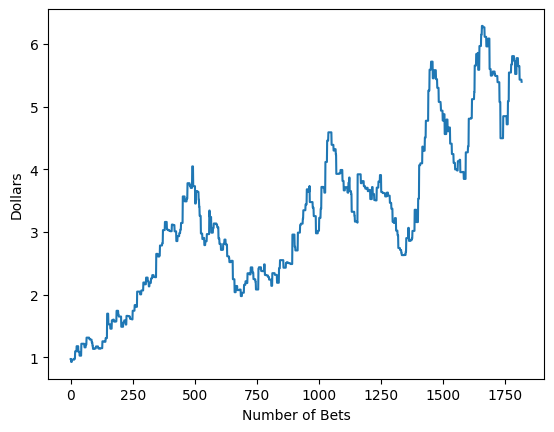

In [150]:
import matplotlib.pyplot as plt

plt.plot(ledger['bankroll_after']/100)
plt.xlabel('Number of Bets')
plt.ylabel('Dollars')

In [99]:
"""
Saving Initial Elo states
"""

from importlib import reload
import utils 
from datetime import datetime
reload(utils)
from utils import SeasonState, save_state

elos_25 = {}

for team, rating in elos.items():
    elos_25[team] = alpha_star * rating + (1-alpha_star) * 1500

state = SeasonState(
    season="2025-26",
    last_updated=datetime.now(),
    init_elo=elos_25,
    params={"K": K_star, "HCA": HCA_star, "scale": scale_star}
)

save_state(state, "../states/2025-26_season_state.pkl")

In [115]:
splitter = PurgedGroupTimeSeriesSplit(n_splits=6, group_gap=1)
final_model, theta, diag = train_calibrated_model(model, X, y, date_groups,
     splitter=splitter,
     reg_lambda=1e-3, bundle_path="../models/elo_model_ensemble_prod.pkl")
